In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load bib

In [3]:
import torch
import random
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import time
import os
import copy
import cv2
import csv

In [4]:
import scipy as sp

In [5]:
matplotlib

Using matplotlib backend: agg


In [6]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.optim import lr_scheduler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms

#batch size
BATCH_SIZE = 32
EPOCHS = 25

In [7]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [8]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

In [9]:
dirs = {
    'train': '../content/drive/MyDrive/DashaDiplom/dataset/train',
    'val': '../content/drive/MyDrive/DashaDiplom/dataset/val',
    'test': '../content/drive/MyDrive/DashaDiplom/dataset/test'
}

# Functions and classes

## Networks

In [56]:
def get_resnet18(pretrained=False, out_features=None, path=None):
    model = torchvision.models.resnet18(pretrained=pretrained)
    if out_features is not None:
        model.fc = torch.nn.Linear(in_features=512, out_features=out_features)
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

In [57]:
def get_densenet121(pretrained=False, out_features=None, path=None):
    model = torchvision.models.densenet121(pretrained=pretrained)
    if out_features is not None:
        model.fc = torch.nn.Linear(in_features=512, out_features=out_features)
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

In [58]:
def get_efficientnetb0(pretrained=False, out_features=None, path=None):
    model = torchvision.models.efficientnet_b0(pretrained=pretrained)
    if out_features is not None:
        model.fc = torch.nn.Linear(in_features=512, out_features=out_features)
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

In [59]:
def get_inception(pretrained=False, out_features=None, path=None):
    model = torchvision.models.inception_v3(pretrained=pretrained)
    num_ftrs_auxLogits = model.AuxLogits.fc.in_features
    num_ftrs = model.fc.in_features
    if out_features is not None:
        model.AuxLogits.fc = torch.nn.Linear(in_features=num_ftrs_auxLogits, out_features=out_features)
        model.fc = torch.nn.Linear(in_features=num_ftrs, out_features=out_features)
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

## Fit Func

In [60]:
def fit(epochs, model, criterion, optimizer, train_dl, valid_dl, lr, size):
    model_name = type(model).__name__.lower()
    optimizer_name = type(optimizer).__name__.lower()
    valid_loss_min = np.Inf
    len_train, len_valid = 17678, 600
    fields = [
        'epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'
    ]
    rows = []

    for epoch in range(epochs):
        train_loss, train_correct = 0, 0
        train_loop = tqdm(train_dl)

        model.train()
        for batch in train_loop:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_correct += get_num_correct(preds, labels)

            train_loop.set_description(f'Epoch [{epoch+1:2d}/{epochs}]')
            train_loop.set_postfix(
                loss=loss.item(), acc=train_correct/len_train
            )
        train_loss = train_loss/len_train
        train_acc = train_correct/len_train

        model.eval()
        with torch.no_grad():
            valid_loss, valid_correct = 0, 0
            for batch in valid_dl:
                images, labels = batch[0].to(device), batch[1].to(device)
                preds = model(images)
                loss = criterion(preds, labels)
                valid_loss += loss.item() * labels.size(0)
                valid_correct += get_num_correct(preds, labels)

            valid_loss = valid_loss/len_valid
            valid_acc = valid_correct/len_valid

            rows.append([epoch, train_loss, train_acc, valid_loss, valid_acc])

            train_loop.write(
                f'\n\t\tAvg train loss: {train_loss:.6f}', end='\t'
            )
            train_loop.write(f'Avg valid loss: {valid_loss:.6f}\n')

            # save model if validation loss has decreased
            # (sometimes also referred as "Early stopping")
            if valid_loss <= valid_loss_min:
                train_loop.write('\t\tvalid_loss decreased', end=' ')
                train_loop.write(f'({valid_loss_min:.6f} -> {valid_loss:.6f})')
                train_loop.write('\t\tsaving model...\n')
                torch.save(
                    model.state_dict(),
                    f'../content/drive/MyDrive/DashaDiplom/models/{model_name}_{size}_{optimizer_name}_{lr}_{device}.pth'
                )
                valid_loss_min = valid_loss

    # write running results for plots
    with open(f'../content/drive/MyDrive/DashaDiplom/outputs/CSVs/{model_name}_{size}_{optimizer_name}_{lr}.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(fields)
        csv_writer.writerows(rows)

In [61]:
def fit_inception(epochs, model, criterion, optimizer, train_dl, valid_dl, lr, size):
    model_name = type(model).__name__.lower()
    optimizer_name = type(optimizer).__name__.lower()
    valid_loss_min = np.Inf
    len_train, len_valid = 17678, 600
    fields = [
        'epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'
    ]
    rows = []

    for epoch in range(epochs):
        train_loss, train_correct = 0, 0
        train_loop = tqdm(train_dl)

        model.train()
        for batch in train_loop:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds, preds_aux = model(images)
            loss1 = criterion(preds, labels)
            loss2 = criterion(preds_aux, labels)
            loss = loss1 + 0.4 * loss2
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_correct += get_num_correct(preds, labels)

            train_loop.set_description(f'Epoch [{epoch+1:2d}/{epochs}]')
            train_loop.set_postfix(
                loss=loss.item(), acc=train_correct/len_train
            )
        train_loss = train_loss/len_train
        train_acc = train_correct/len_train

        model.eval()
        with torch.no_grad():
            valid_loss, valid_correct = 0, 0
            for batch in valid_dl:
                images, labels = batch[0].to(device), batch[1].to(device)
                preds = model(images)
                loss = criterion(preds, labels)
                valid_loss += loss.item() * labels.size(0)
                valid_correct += get_num_correct(preds, labels)

            valid_loss = valid_loss/len_valid
            valid_acc = valid_correct/len_valid

            rows.append([epoch, train_loss, train_acc, valid_loss, valid_acc])

            train_loop.write(
                f'\n\t\tAvg train loss: {train_loss:.6f}', end='\t'
            )
            train_loop.write(f'Avg valid loss: {valid_loss:.6f}\n')

            # save model if validation loss has decreased
            # (sometimes also referred as "Early stopping")
            if valid_loss <= valid_loss_min:
                train_loop.write('\t\tvalid_loss decreased', end=' ')
                train_loop.write(f'({valid_loss_min:.6f} -> {valid_loss:.6f})')
                train_loop.write('\t\tsaving model...\n')
                torch.save(
                    model.state_dict(),
                    f'../content/drive/MyDrive/DashaDiplom/models/{model_name}_{size}_{optimizer_name}_{lr}_{device}.pth'
                )
                valid_loss_min = valid_loss

    # write running results for plots
    with open(f'../content/drive/MyDrive/DashaDiplom/outputs/CSVs/{model_name}_{size}_{optimizer_name}_{lr}.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(fields)
        csv_writer.writerows(rows)

In [62]:
def fit_sheduler(epochs, model, criterion, optimizer, scheduler, train_dl, valid_dl, size):
    model_name = type(model).__name__.lower()
    optimizer_name = type(optimizer).__name__.lower()
    scheduler_name = type(scheduler).__name__.lower()
    valid_loss_min = np.Inf
    len_train, len_valid = 17678, 600
    fields = [
        'epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'
    ]
    rows = []

    for epoch in range(epochs):
        train_loss, train_correct = 0, 0
        train_loop = tqdm(train_dl)

        model.train()
        for batch in train_loop:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_correct += get_num_correct(preds, labels)

            train_loop.set_description(f'Epoch [{epoch+1:2d}/{epochs}]')
            train_loop.set_postfix(
                loss=loss.item(), acc=train_correct/len_train
            )

        train_loss = train_loss/len_train
        train_acc = train_correct/len_train

        scheduler.step()

        model.eval()
        with torch.no_grad():
            valid_loss, valid_correct = 0, 0
            for batch in valid_dl:
                images, labels = batch[0].to(device), batch[1].to(device)
                preds = model(images)
                loss = criterion(preds, labels)
                valid_loss += loss.item() * labels.size(0)
                valid_correct += get_num_correct(preds, labels)

            valid_loss = valid_loss/len_valid
            valid_acc = valid_correct/len_valid

            rows.append([epoch, train_loss, train_acc, valid_loss, valid_acc])

            train_loop.write(
                f'\n\t\tAvg train loss: {train_loss:.6f}', end='\t'
            )
            train_loop.write(f'Avg valid loss: {valid_loss:.6f}\n')

            # save model if validation loss has decreased
            # (sometimes also referred as "Early stopping")
            if valid_loss <= valid_loss_min:
                train_loop.write('\t\tvalid_loss decreased', end=' ')
                train_loop.write(f'({valid_loss_min:.6f} -> {valid_loss:.6f})')
                train_loop.write('\t\tsaving model...\n')
                torch.save(
                    model.state_dict(),
                    f'../content/drive/MyDrive/DashaDiplom/models/{model_name}_{size}_{optimizer_name}_{scheduler_name}_{device}.pth'
                )
                valid_loss_min = valid_loss

    # write running results for plots
    with open(f'../content/drive/MyDrive/DashaDiplom/outputs/CSVs/{model_name}_{size}_{optimizer_name}_{scheduler_name}.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(fields)
        csv_writer.writerows(rows)

## Plot Func

In [63]:
def plot_summary(path, model_name, size, optimizer_name, lr):
    data = pd.read_csv(path)

    plt.style.use('seaborn-whitegrid')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    ax1.plot(data['epoch'], data['train_loss'], label='Ошибка на обучающих данных', linestyle = '--', color='#F47C7C')
    ax1.plot(data['epoch'], data['valid_loss'], label='Ошибка на проверочных данных', color='#F47C7C')
    ax1.axhline(data['valid_loss'].min(), linestyle=(0, (5, 10)), linewidth=0.5)
    ax1.axvline(data['valid_loss'].idxmin(), linestyle=(0, (5, 10)), linewidth=0.5)
    ax1.text(11, data['valid_loss'].min(), 'мин. знач. ошибки', backgroundcolor='white', va='center', size=7.5)

    ax2.plot(data['epoch'], data['train_acc'], label='Правильность на обучающих данных', linestyle = '--', color='#A1DE93')
    ax2.plot(data['epoch'], data['valid_acc'], label='Правильность на проверочных данных', color='#A1DE93')

    ax1.legend()
    ax1.set_title('Значение ошибки', fontweight='bold')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Ошибка')
    ax1.grid(True)

    ax2.legend()
    ax2.set_title('Значение правильности', fontweight='bold')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Правильность')
    ax2.grid(True)

    plt.tight_layout()
    fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/{model_name}_{size}_{optimizer_name}_{lr}.png')
    plt.show()
    plt.close()

In [64]:
def plot_confmat(train_mat, test_mat, classes, model_name, size, optimizer_name, lr):
    train_mat = pd.DataFrame(train_mat.numpy(), index=classes, columns=classes)
    test_mat = pd.DataFrame(test_mat.numpy(), index=classes, columns=classes)

    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(16, 6))

    ax = fig.add_subplot(121)
    ax = sns.heatmap(train_mat, annot=True, cmap='Blues',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Матрица ошибок (Тренировочный набор)', fontweight='bold')
    ax.set_xlabel('Предсказанный класс', fontweight='bold')
    ax.set_ylabel('Действительный класс', fontweight='bold')

    ax = fig.add_subplot(122)
    ax = sns.heatmap(test_mat, annot=True, cmap='Blues',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Матрица ошибок (Тестовый набор)', fontweight='bold')
    ax.set_xlabel('Предсказанный класс', fontweight='bold')
    ax.set_ylabel('Действительный класс', fontweight='bold')

    plt.tight_layout()
    fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/confusion_matrices/{model_name}_{size}_{optimizer_name}_{lr}.png')
    plt.show()
    plt.close()

In [101]:
#def plot_gradcam(image, vgg_cam, res_cam, dense_cam):
def plot_gradcam(image, dense_cam):
    image = deprocess_image(image)
    name_dict = {
        'Оригинальное изображение': image,
        'GradCAM (EfficientNet-BO)': apply_mask(image, dense_cam),
    }

    plt.style.use('seaborn-notebook')
    fig = plt.figure(figsize=(20, 4))
    for i, (name, img) in enumerate(name_dict.items()):
        ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        if i:
            img = img[:, :, ::-1]
        ax.imshow(img)
        ax.set_xlabel(name, fontweight='bold')

    plt.tight_layout()
    fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/gradcam/1.pdf')
    plt.show()
    plt.close()

In [66]:
#def plot_gradcam(image, vgg_cam, res_cam, dense_cam):
def plot_gradcam(image, res_cam, dense_cam, eff_cam):
    image = deprocess_image(image)
    name_dict = {
        'Оригинальное изображение': image,
        'GradCAM (ResNet-18)': apply_mask(image, res_cam),
        'GradCAM (DenseNet-121)': apply_mask(image, dense_cam),
        'GradCAM (EfficientNet-BO)': apply_mask(image, eff_cam),
    }

    plt.style.use('seaborn-notebook')
    fig = plt.figure(figsize=(20, 4))
    for i, (name, img) in enumerate(name_dict.items()):
        ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        if i:
            img = img[:, :, ::-1]
        ax.imshow(img)
        ax.set_xlabel(name, fontweight='bold')
    
    ax.set_title('Визуализация локализации болезни с помощью GradCAM',
        fontweight='bold', fontsize=16)

    plt.tight_layout()
    plt.show()
    plt.close()

In [67]:
def wif(id):
    process_seed = torch.initial_seed()
    base_seed = process_seed - id
    ss = np.random.SeedSequence([id, base_seed])
    # More than 128 bits (4 32-bit words) would be overkill.
    np.random.seed(ss.generate_state(4))

In [68]:
def get_all_preds(model, loader):
    model.eval()
    with torch.no_grad():
        all_preds = torch.tensor([], device=device)
        for batch in loader:
            images = batch[0].to(device)
            preds = model(images)
            all_preds = torch.cat((all_preds, preds), dim=0)

    return all_preds

In [69]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [70]:
def get_confmat(targets, preds):
    stacked = torch.stack(
        (torch.as_tensor(targets, device=device),
         preds.argmax(dim=1)), dim=1
    ).tolist()
    confmat = torch.zeros(4, 4, dtype=torch.int16)
    for t, p in stacked:
        confmat[t, p] += 1

    return confmat

In [71]:
def get_results(confmat, classes):
    results = {}
    d = confmat.diagonal()
    for i, l in enumerate(classes):
        tp = d[i].item()
        tn = d.sum().item() - tp
        fp = confmat[i].sum().item() - tp
        fn = confmat[:, i].sum().item() - tp

        accuracy = (tp+tn)/(tp+tn+fp+fn)
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        f1score = (2*precision*recall)/(precision+recall)

        results[l] = [accuracy, recall, precision, f1score]

        print(f'Class name: {l}\nAccuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\nF1-score: {f1score}')
        print(' ')

In [72]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.featuremaps = []
        self.gradients = []

        target_layer.register_forward_hook(self.save_featuremaps)
        target_layer.register_backward_hook(self.save_gradients)

    def save_featuremaps(self, module, input, output):
        self.featuremaps.append(output)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0])

    def get_cam_weights(self, grads):
        return np.mean(grads, axis=(1, 2))

    def __call__(self, image, label=None):
        preds = self.model(image)
        self.model.zero_grad()

        if label is None:
            label = preds.argmax(dim=1).item()

        preds[:, label].backward()

        featuremaps = self.featuremaps[-1].cpu().data.numpy()[0, :]
        gradients = self.gradients[-1].cpu().data.numpy()[0, :]

        weights = self.get_cam_weights(gradients)
        cam = np.zeros(featuremaps.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * featuremaps[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, image.shape[-2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return label, cam

In [73]:
def deprocess_image(image):
    image = image.cpu().numpy()
    image = np.squeeze(np.transpose(image[0], (1, 2, 0)))
    image = image * std_nums + mean_nums  # un-normalize
    image = image.clip(0, 1)
    return image

In [74]:
def apply_mask(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [75]:
def name_of_class(label):
  if label == 0:
    return 'covid'
  else:
    return 'normal'

# Show data

In [80]:
data_transforms = {
    'train': transforms.Compose([
      transforms.ToTensor()
    ]),

    'val': transforms.Compose([
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToTensor()
    ]),
}

In [81]:
data_dir = '../content/drive/MyDrive/DashaDiplom/dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

In [ ]:
len(image_datasets['train'])

17668

In [ ]:
len(image_datasets['val'])

600

In [ ]:
len(image_datasets['test'])

600

In [ ]:
freq_train = torch.as_tensor(image_datasets['train'].targets).bincount()
freq_val = torch.as_tensor(image_datasets['val'].targets).bincount()
freq_test = torch.as_tensor(image_datasets['test'].targets).bincount()
freq_all = freq_train + freq_test + freq_val

In [ ]:
def log_freq(dset, dfreq):
    for c, i in dset.class_to_idx.items():
        print(f'Number of {c.capitalize()} X-Rays: {dfreq[i].item()}')

In [ ]:
print('========== Train Set ==========')
log_freq(image_datasets['train'], freq_train)
print('======== Validation Set ========')
log_freq(image_datasets['val'], freq_val)
print('=========== Test Set ===========')
log_freq(image_datasets['test'], freq_test)

========== Train Set ==========
Number of Covid X-Rays: 3315
Number of Lungopacity X-Rays: 3416
Number of Normal X-Rays: 9892
Number of Pneumonia X-Rays: 1045
======== Validation Set ========
Number of Covid X-Rays: 150
Number of Lungopacity X-Rays: 150
Number of Normal X-Rays: 150
Number of Pneumonia X-Rays: 150
=========== Test Set ===========
Number of Covid X-Rays: 150
Number of Lungopacity X-Rays: 150
Number of Normal X-Rays: 150
Number of Pneumonia X-Rays: 150


In [ ]:
def imshow(img, size =(13,13)):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=size)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
class_names = dataloaders['train'].dataset.classes

In [ ]:
#Get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

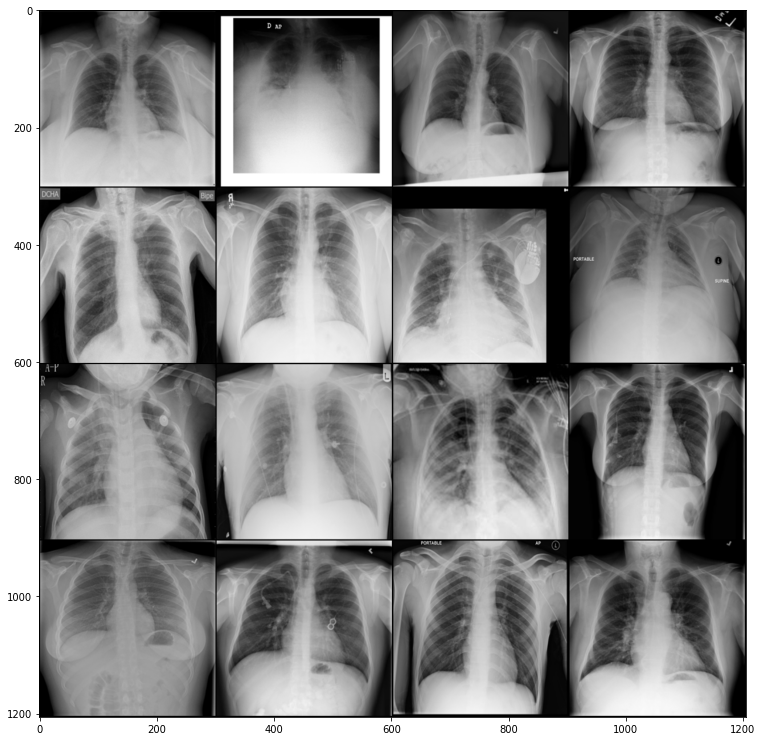

In [ ]:
#Show images
imshow(torchvision.utils.make_grid(images, nrow=4))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(16)))

In [ ]:
idx2class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
idx2class

{0: 'covid', 1: 'lungOpacity', 2: 'normal', 3: 'pneumonia'}

In [ ]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [ ]:
print("Distribution of classes: \n", get_class_distribution(image_datasets['train']))

In [ ]:
data = pd.DataFrame.from_dict([get_class_distribution(image_datasets['train'])]).melt()

In [ ]:
data

,variable,value
0,covid,3315
1,lungOpacity,3416
2,normal,9892
3,pneumonia,1045


In [41]:
data = {'Covid':3315, 'Пневмония':1045, 'Помутнения в легких':3416, 'Чистые легкие':9892}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color=['#A9D3FF', '#429EFF', '#005DBD', '#003C7B'])
 
plt.xlabel("Название класса", fontsize=12)
plt.ylabel("Количество изображений", fontsize=12)
plt.title("Количество изображений в классах", fontweight='bold', fontsize=14)
fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/ds_sample.pdf')

# Func Activation

In [ ]:
def sig(x):
  return 1/(1 + np.exp(-x))

def tanh(x):
  return np.tanh(x)

def relu(x):
  return np.maximum(0, x)

def softplus(x):
  return np.log(1 + np.exp(x))

In [ ]:
def fsig(x):
  return sig(x)*(1-sig(x))

In [ ]:
x = np.linspace(-5, 5, 50) 

In [ ]:
sig = sig(x)
tanh = tanh(x)
relu = relu(x)

In [ ]:
fsig = fsig(x)

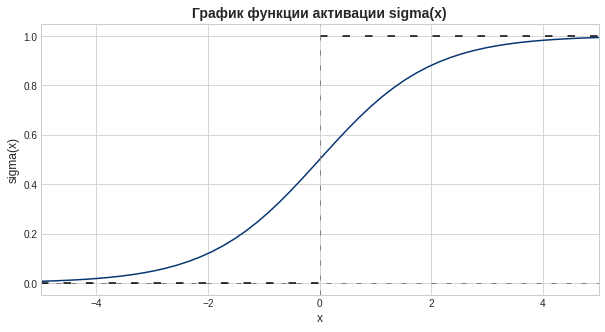

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot()
ax.plot(x, sig, color='#083673')
ax.axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.plot(np.linspace(0, 5, 25), np.linspace(1, 1, 25), linestyle=(0, (5, 10)), color='k')
ax.plot(np.linspace(-5, 0, 25), np.linspace(0, 0, 25), linestyle=(0, (5, 10)), color='k')
ax.axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")

ax.set_xlim(-5, 5)
ax.set_title('График функции активации sigma(x)', fontweight='bold', fontsize=14)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('sigma(x)', fontsize=12);
fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/func_activ_sig.png')

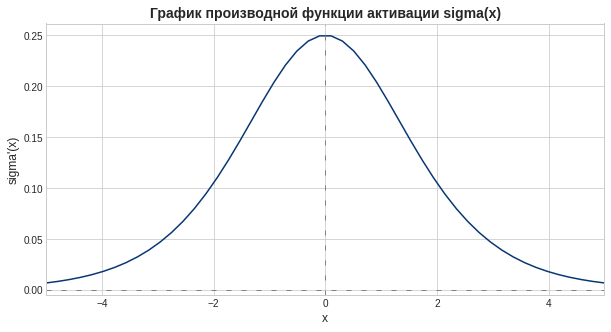

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot()
ax.plot(x, fsig, color='#083673')
ax.axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")

ax.set_xlim(-5, 5)
ax.set_title('График производной функции активации sigma(x)', fontweight='bold', fontsize=14)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel("sigma'(x)", fontsize=12);
fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/func_activ_fsig.png')

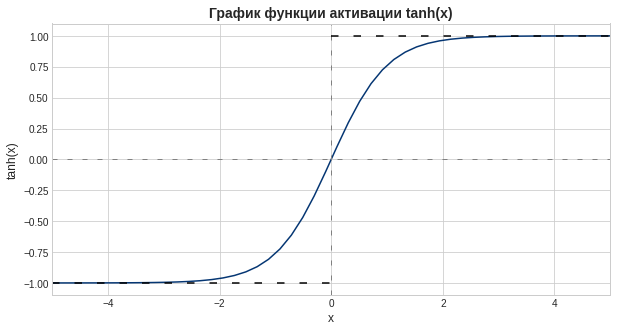

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot()
ax.plot(x, tanh, color='#053673')
ax.axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.plot(np.linspace(0, 5, 25), np.linspace(1, 1, 25), linestyle=(0, (5, 10)), color='k')
ax.plot(np.linspace(-5, 0, 25), np.linspace(-1, -1, 25), linestyle=(0, (5, 10)), color='k')
ax.set_xlim(-5, 5)

ax.set_title('График функции активации tanh(x)', fontweight='bold', fontsize=14)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('tanh(x)', fontsize=12);
fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/func_activ_tanh.png')

In [ ]:
def relu(x):
  return np.maximum(0, x)

In [ ]:
np.linspace(0, 5, 25)

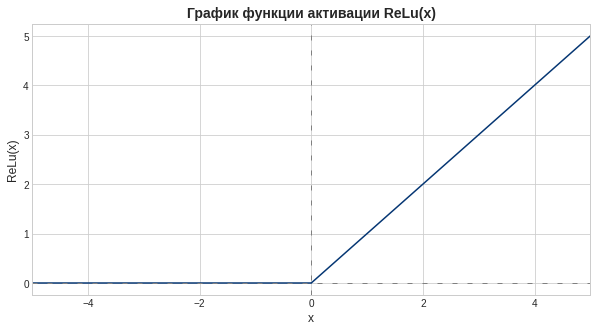

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot()
ax.plot(np.linspace(-5, 0, 25), np.linspace(0, 0, 25), color='#053673')
ax.plot(np.linspace(0, 5, 25), np.linspace(0, 5, 25), color='#053673')
ax.axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.set_xlim(-5, 5)

ax.set_title('График функции активации ReLu(x)', fontweight='bold', fontsize=14)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('ReLu(x)', fontsize=12);
fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/func_activ_relu.png')

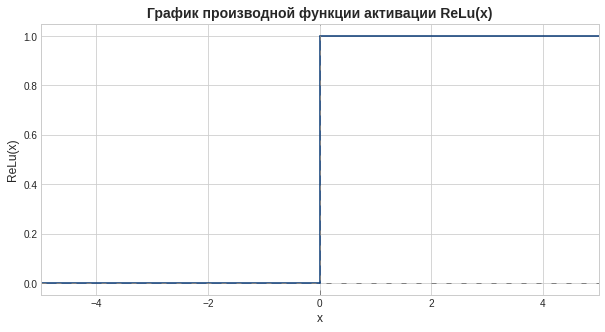

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot()
ax.plot(np.linspace(-5, 0, 25), np.linspace(0, 0, 25), color='#053673')
ax.plot(np.linspace(0, 5, 25), np.linspace(1, 1, 25), color='#053673')
ax.plot(np.linspace(0, 0, 25), np.linspace(0, 1, 25), color='#053673')
ax.axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.set_xlim(-5, 5)

ax.set_title('График производной функции активации ReLu(x)', fontweight='bold', fontsize=14)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('ReLu(x)', fontsize=12);
fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/func_activ_frelu.png')

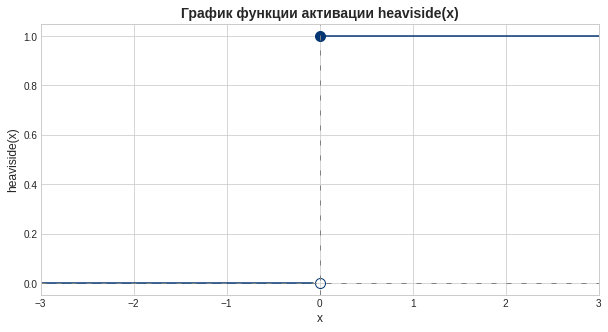

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot()
ax.plot(np.linspace(-3, -0.07, 25), np.linspace(0, 0, 25), color='#053673')
ax.plot(np.linspace(0, 3, 25), np.linspace(1, 1, 25), color='#053673')
ax.plot(0, 0, marker='o', markeredgecolor='#053673', markersize=10, fillstyle='none', color='#053673')
ax.plot(0, 1, marker='o', markersize=10, color='#053673')
ax.axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax.set_xlim(-3, 3)

ax.set_title('График функции активации heaviside(x)', fontweight='bold', fontsize=14)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('heaviside(x)', fontsize=12);
fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/func_activ_heaviside.png')

In [ ]:
alpha = 1.6732
lmbd = 1.0507

def plus_elu(x):
  return x

def minus_elu(x):
  return (0.2 * (np.exp(x) - 1))

def plus_LReLU(x):
  return x

def minus_LReLU(x):
  return 0.2 * x

def plus_SELU(x):
  return lmbd * x

def minus_SELU(x):
  return lmbd * (alpha * np.exp(x) - alpha)

def GELU(x):
  return 0.5*x*(1 + np.tanh(np.sqrt(2/np.pi)*(x + 0.044715 * x**3)))

In [ ]:
x = np.linspace(-5, 0, 25)

In [ ]:
x2 = np.linspace(0, 5, 25)

In [ ]:
minus_elu = minus_elu(x)
plus_elu = plus_elu(x2)

In [ ]:
minus_LReLU = minus_LReLU(x)
plus_LReLU = plus_LReLU(x2)

In [ ]:
minus_SELU = minus_SELU(x)
plus_SELU = plus_SELU(x2)

In [ ]:
x1 = np.linspace(-5, 5, 50)

In [ ]:
GELU = GELU(x1)

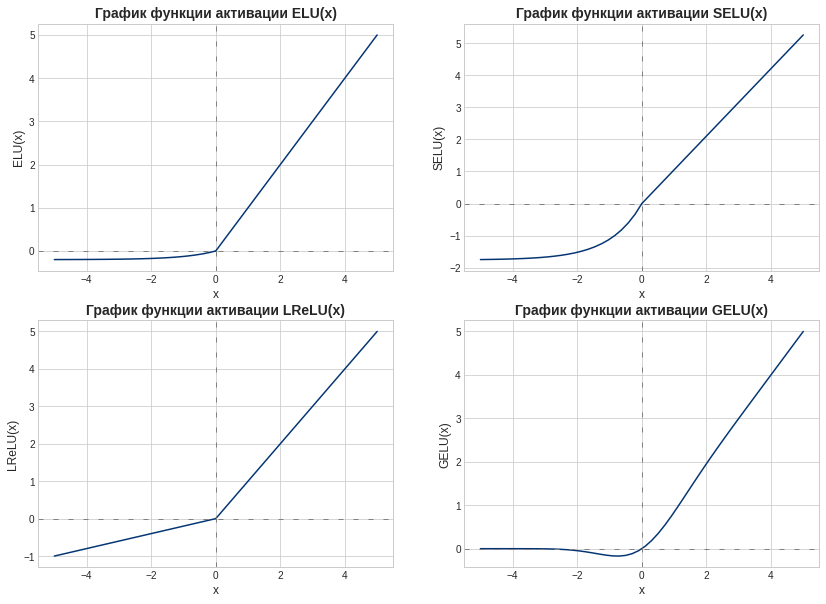

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].plot(x, minus_elu, color='#053673', label='ELU')
ax[0, 0].plot(x2, plus_elu, color='#053673')
ax[0, 0].axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax[0, 0].axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax[0, 0].set_title('График функции активации ELU(x)', fontweight='bold', fontsize=14)
ax[0, 0].set_xlabel('x', fontsize=12)
ax[0, 0].set_ylabel('ELU(x)', fontsize=12)

ax[1, 0].plot(x, minus_LReLU, color='#053673', label='LReLU')
ax[1, 0].plot(x2, plus_LReLU, color='#053673')
ax[1, 0].axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax[1, 0].axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax[1, 0].set_title('График функции активации LReLU(x)', fontweight='bold', fontsize=14)
ax[1, 0].set_xlabel('x', fontsize=12)
ax[1, 0].set_ylabel('LReLU(x)', fontsize=12)

ax[0, 1].plot(x, minus_SELU, color='#053673', label='SELU')
ax[0, 1].plot(x2, plus_SELU, color='#053673')
ax[0, 1].axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax[0, 1].axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax[0, 1].set_title('График функции активации SELU(x)', fontweight='bold', fontsize=14)
ax[0, 1].set_xlabel('x', fontsize=12)
ax[0, 1].set_ylabel('SELU(x)', fontsize=12)

ax[1, 1].plot(x1, GELU, color='#053673')
ax[1, 1].axhline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax[1, 1].axvline(0, linestyle=(0, (5, 10)), linewidth=1, color="grey")
ax[1, 1].set_title('График функции активации GELU(x)', fontweight='bold', fontsize=14)
ax[1, 1].set_xlabel('x', fontsize=12)
ax[1, 1].set_ylabel('GELU(x)', fontsize=12)

fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/func_activ_mod_relu.png')

# SimpleNet 128, слоев: 7 (1000->бн->600->бн->400->бн->200->бн->100->бн->50->2), ауг: +9, скорость: 0.0001

In [ ]:
train_transform = transforms.Compose([
                                      transforms.Resize(128),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                      transforms.RandomCrop(size=(128, 128)),
                                      transforms.RandomRotation(5),
                                      transforms.RandomPosterize(bits=2),
                                      transforms.RandomAdjustSharpness(sharpness_factor=3),
                                      transforms.RandomAutocontrast(),
                                      transforms.RandomInvert(),
                                      transforms.RandomEqualize(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          mean = mean_nums,
                                          std = std_nums
                                      )
])

val_test_transform = transforms.Compose([
                                           transforms.Resize(128),
                                           transforms.ToTensor(),
                                           transforms.Normalize(
                                                mean = mean_nums,
                                                std = std_nums
                                          )
])

In [ ]:
train_data = datasets.ImageFolder(
    root = '../content/drive/MyDrive/diplom/dataset/Dataset/train',
    transform = train_transform
)

val_data = datasets.ImageFolder(
    root = '../content/drive/MyDrive/diplom/dataset/Dataset/val',
    transform = val_test_transform
)

test_data = datasets.ImageFolder(
    root = '../content/drive/MyDrive/diplom/dataset/Dataset/test',
    transform = val_test_transform
)

In [ ]:
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

In [ ]:
class SimpleNet128(nn.Module):

    def __init__(self):
        super(SimpleNet128, self).__init__()
        self.fc1 = nn.Linear(128*128*3, 1000)
        #self.fc1 = nn.Linear(224*224*3, 25000)
        #self.fc2 = nn.Linear(25000, 5000)
        #self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 600)
        #self.fc2 = nn.Linear(1000, 600)
        self.fc4 = nn.Linear(600, 400)
        #self.fc2 = nn.Linear(1000, 400)
        #self.fc3 = nn.Linear(400, 200)
        self.fc5 = nn.Linear(400, 200)
        self.fc6 = nn.Linear(200, 100)
        self.fc7 = nn.Linear(100, 50)
        #self.fc6 = nn.Linear(200, 50)
        self.fc8 = nn.Linear(50,2)

        self.bn1 = nn.BatchNorm1d(1000)
        self.bn2 = nn.BatchNorm1d(600)
        self.bn3 = nn.BatchNorm1d(400)
        self.bn4 = nn.BatchNorm1d(200)
        self.bn5 = nn.BatchNorm1d(100)
        self.bn6 = nn.BatchNorm1d(50)

    
    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc3(x))
        x = self.bn2(x)
        x = F.relu(self.fc4(x))
        x = self.bn3(x)
        x = F.relu(self.fc5(x))
        x = self.bn4(x)
        x = F.relu(self.fc6(x))
        x = self.bn5(x)
        x = F.relu(self.fc7(x))
        x = self.bn6(x)
        x = self.fc8(x)
        return x

In [ ]:
simplenet = SimpleNet128()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [ ]:
simplenet.to(device)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(simplenet.parameters(), lr=0.0001)

In [ ]:
test_accuracy_history = []
test_loss_history = []
train_accuracy_history = []
train_loss_history = []

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
    for epoch in range(1, epochs+1):
        print('Epoch: {}'.format(epoch))
        training_loss = 0.0
        valid_loss = 0.0

        model.train()
        num_correct = 0 
        num_examples = 0

        for batch in train_loader:
            optimizer.zero_grad()

            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            output = model(inputs)

            loss = loss_fn(output, targets)
            loss.backward()

            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

        training_loss /= len(train_loader.dataset)
        train_loss_history.append(training_loss)

        train_accuracy = num_correct/num_examples
        train_accuracy_history.append(train_accuracy)
        
        model.eval()
        num_correct = 0 
        num_examples = 0

        for batch in val_loader:

            inputs, targets = batch
            inputs = inputs.to(device)

            output = model(inputs)
            targets = targets.to(device)

            loss = loss_fn(output,targets)

            valid_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        
        valid_loss /= len(val_loader.dataset)
        test_loss_history.append(valid_loss)

        val_accuracy = num_correct/num_examples
        test_accuracy_history.append(val_accuracy)

        print('train loss: {:.2f}, train accuracy = {:.2f}, val loss: {:.2f}, val accuracy = {:.2f}'.format(
            training_loss,
            train_accuracy,
            valid_loss,
            val_accuracy))

In [ ]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=100, device=device)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
num_epochs = 100
ax.grid(True)
ax.plot(np.arange(0, num_epochs), train_loss_history, label="Ошибка на обучающих данных", lw=2, linestyle = '--', color='#F47C7C')
ax.plot(np.arange(0, num_epochs), test_loss_history, label="Ошибка на проверочных данных", lw=2, color='#F47C7C')
ax.plot(np.arange(0, num_epochs), train_accuracy_history, label="Правильность на проверочных данных", lw=2, color='#A1DE93')
ax.plot(np.arange(0, num_epochs), test_accuracy_history, label="Правильность на обучающих данных", lw=2, linestyle = '--', color='#A1DE93')
ax.legend()
ax.set_xlim(0,num_epochs-1)
ax.set_xlabel('Количество эпох', fontsize=12)
ax.set_ylabel('Значение ошибки и правильности', fontsize=12)
plt.tight_layout()
plt.show()

# Scheduler

## ResNet18 224 adam sheduler

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=64, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet18 = get_resnet18(pretrained=True, out_features=4)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
lr_find_epochs = 2
start_lr = 1e-7
end_lr = 0.1

In [ ]:
1e-7 - math.exp(64 * math.log(end_lr / start_lr) / (lr_find_epochs * len(train_dl)))

-4.933337022252581

In [ ]:
optimizer=optim.Adam(resnet18.parameters(), start_lr)

In [ ]:
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(train_dl)))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
# Make lists to capture the logs

lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05

for i in range(lr_find_epochs):
  print("epoch {}".format(i))
  for inputs, labels in train_dl:

    print("iter 554/{}".format(iter))
    # Send to device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Training mode and zero gradients
    resnet18.train()
    optimizer.zero_grad()
    
    # Get outputs to calc loss
    outputs = resnet18(inputs)
    loss = criterion(outputs, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_find_lr.append(lr_step)

    # smooth the loss
    if iter==0:
      lr_find_loss.append(loss)
    else:
      loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
      lr_find_loss.append(loss)
     
    iter += 1

In [ ]:
lr_find_loss_np = [0 for i in range(0, len(lr_find_loss))]

In [ ]:
for i in range(0, len(lr_find_loss)):
  lr_find_loss_np[i] = lr_find_loss[i].cpu().detach().numpy()
  i = i + 1

In [ ]:
with open(f'../content/drive/MyDrive/DashaDiplom/outputs/scheduler/resnet1_find_lr.pickle','wb') as file:
    pickle.dump(lr_find_lr, file)

with open(f'../content/drive/MyDrive/DashaDiplom/outputs/scheduler/resnet1_find_loss.pickle','wb') as file:
    pickle.dump(lr_find_loss_np, file)

In [16]:
with open("../content/drive/MyDrive/DashaDiplom/outputs/scheduler/resnet/resnet18_find_lr.pickle","rb") as file:
    lr_find_lr = pickle.load(file)

with open("../content/drive/MyDrive/DashaDiplom/outputs/scheduler/resnet/resnet18_find_loss.pickle","rb") as file:
    lr_find_loss_np = pickle.load(file)

In [ ]:
lr_find_lr

In [31]:
lr_find_loss_np.index(min(lr_find_loss_np))

317

In [34]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot()
ax.plot(range(len(lr_find_lr)), lr_find_lr, color='#083673')

ax.set_title('Экспоненциальное изменение скорости обучения', fontweight='bold', fontsize=14)
ax.set_xlabel('Шаг', fontsize=12)
ax.set_ylabel('Скорость обучения', fontsize=12);
plt.show()
#fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/scheduler/scheduler.png')

In [36]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot()
plt.xscale("log")
ax.plot(lr_find_lr, lr_find_loss_np, color='#083673')
ax.axvline(lr_find_lr[315], linestyle=(0, (5, 10)), linewidth=1, color="red")
ax.axvline(lr_find_lr[85], linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.set_xlim(1e-7, 1e-1)
ax.set_title('Значение ошибки от скорости обучения для сети ResNet-18', fontweight='bold', fontsize=14)
ax.set_xlabel('Скорость обучения', fontsize=12)
ax.set_ylabel('Значение ошибки', fontsize=12)

fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/scheduler/resnet/scheduler_resnet18.pdf')

In [ ]:
lr_find_lr[553]

0.11614003416618446

In [ ]:
lr_find_lr[315]

In [ ]:
lr_find_lr[315] / 10

3.0715997313939e-05

In [ ]:
lr_find_lr[86]

1.0167641301994282e-06

## DenseNet 121 224 adam sheduler

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=64, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
densenet121 = get_densenet121(pretrained=True, out_features=4)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
lr_find_epochs = 2
start_lr = 1e-7
end_lr = 0.1

In [ ]:
optimizer=optim.Adam(densenet121.parameters(), start_lr)

In [ ]:
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(train_dl)))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
# Make lists to capture the logs

lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05

for i in range(lr_find_epochs):
  print("epoch {}".format(i))
  for inputs, labels in train_dl:

    print("iter 554/{}".format(iter))
    # Send to device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Training mode and zero gradients
    densenet121.train()
    optimizer.zero_grad()
    
    # Get outputs to calc loss
    outputs = densenet121(inputs)
    loss = criterion(outputs, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_find_lr.append(lr_step)

    # smooth the loss
    if iter==0:
      lr_find_loss.append(loss)
    else:
      loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
      lr_find_loss.append(loss)
     
    iter += 1

In [ ]:
lr_find_loss_np = [0 for i in range(0, len(lr_find_loss))]

In [ ]:
for i in range(0, len(lr_find_loss)):
  lr_find_loss_np[i] = lr_find_loss[i].cpu().detach().numpy()
  i = i + 1

In [ ]:
with open(f'../content/drive/MyDrive/DashaDiplom/outputs/scheduler/densenet121_find_lr.pickle','wb') as file:
    pickle.dump(lr_find_lr, file)

with open(f'../content/drive/MyDrive/DashaDiplom/outputs/scheduler/densenet121_find_loss.pickle','wb') as file:
    pickle.dump(lr_find_loss_np, file)

In [17]:
with open("../content/drive/MyDrive/DashaDiplom/outputs/scheduler/densenet/densenet121_find_lr.pickle","rb") as file:
    lr_find_lr1 = pickle.load(file)

with open("../content/drive/MyDrive/DashaDiplom/outputs/scheduler/densenet/densenet121_find_loss.pickle","rb") as file:
    lr_find_loss_np1 = pickle.load(file)

In [ ]:
lr_find_loss_np.index(min(lr_find_loss_np))

179

In [ ]:
lr_find_lr[92]

1.0167641301994282e-06

In [ ]:
lr_find_lr[274] / 10

9.513478700408472e-06

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot()
plt.xscale("log")

ax.plot(lr_find_lr, lr_find_loss_np, color='#083673')
ax.axvline(lr_find_lr[91], linestyle=(0, (5, 10)), linewidth=1, color="red")
ax.axvline(lr_find_lr[274], linestyle=(0, (5, 10)), linewidth=1, color="red")
ax.set_xlim(1e-7, 1e-1)
ax.set_title('Значение ошибки от скорости обучения для сети DenseNet-121', fontweight='bold', fontsize=14)
ax.set_xlabel('Скорость обучения', fontsize=12)
ax.set_ylabel('Значение ошибки', fontsize=12)

fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/scheduler/densenet/scheduler_densenet121.png')

## EfficientNet 224 adam sheduler

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=64, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
efficientnet = get_efficientnetb0(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
lr_find_epochs = 2
start_lr = 1e-7
end_lr = 0.1

In [ ]:
optimizer=optim.Adam(efficientnet.parameters(), start_lr)

In [ ]:
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(train_dl)))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
# Make lists to capture the logs

lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05

for i in range(lr_find_epochs):
  print("epoch {}".format(i))
  for inputs, labels in train_dl:

    print("iter 554/{}".format(iter))
    # Send to device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Training mode and zero gradients
    efficientnet.train()
    optimizer.zero_grad()
    
    # Get outputs to calc loss
    outputs = efficientnet(inputs)
    loss = criterion(outputs, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_find_lr.append(lr_step)

    # smooth the loss
    if iter==0:
      lr_find_loss.append(loss)
    else:
      loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
      lr_find_loss.append(loss)
     
    iter += 1

In [ ]:
lr_find_loss_np = [0 for i in range(0, len(lr_find_loss))]

In [ ]:
for i in range(0, len(lr_find_loss)):
  lr_find_loss_np[i] = lr_find_loss[i].cpu().detach().numpy()
  i = i + 1

In [ ]:
with open(f'../content/drive/MyDrive/DashaDiplom/outputs/scheduler/efficientnet_find_lr.pickle','wb') as file:
    pickle.dump(lr_find_lr, file)

with open(f'../content/drive/MyDrive/DashaDiplom/outputs/scheduler//efficientnet_find_loss.pickle','wb') as file:
    pickle.dump(lr_find_loss_np, file)

In [18]:
with open("../content/drive/MyDrive/DashaDiplom/outputs/scheduler/efficientnet/efficientnet_find_lr.pickle","rb") as file:
    lr_find_lr2 = pickle.load(file)

with open("../content/drive/MyDrive/DashaDiplom/outputs/scheduler/efficientnet/efficientnet_find_loss.pickle","rb") as file:
    lr_find_loss_np2 = pickle.load(file)

In [ ]:
lr_find_lr[184]

1.0083472270004159e-05

In [ ]:
lr_find_lr[368]

0.000991721872409718

In [ ]:
0.000991721872409718/10

9.91721872409718e-05

In [ ]:
0.0009 / 10

8.999999999999999e-05

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot()
plt.xscale("log")
ax.plot(lr_find_lr, lr_find_loss_np, color='#083673')
ax.axvline(lr_find_lr[184], linestyle=(0, (5, 10)), linewidth=1, color="red")
ax.axvline(lr_find_lr[368], linestyle=(0, (5, 10)), linewidth=1, color="red")
ax.set_xlim(1e-7, 1e-1)

ax.set_title('Значение ошибки от скорости обучения для сети EfficientNet-B0', fontweight='bold', fontsize=14)
ax.set_xlabel('Скорость обучения', fontsize=12)
ax.set_ylabel('Значение ошибки', fontsize=12)

fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/scheduler/efficientnet/scheduler_efficientnet.png')

In [21]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(11, 4))

ax = fig.add_subplot()
plt.xscale("log")
ax.plot(lr_find_lr, lr_find_loss_np, label='Ошибка сети ResNet-18', color="#003C7B")
ax.plot(lr_find_lr1, lr_find_loss_np1, label='Ошибка сети DenseNet-121', color="#429EFF")
ax.plot(lr_find_lr2, lr_find_loss_np2, label='Ошибка сети EfficientNet-B0', color="#A9D3FF")

ax.axvline(lr_find_lr[315], linestyle=(0, (5, 10)), linewidth=1, color="#003C7B", label='Оптимальный интервал ResNet-18',)
ax.axvline(lr_find_lr[84], linestyle=(0, (5, 10)), linewidth=1, color="#003C7B")

ax.axvline(lr_find_lr1[91], linestyle=(0, (5, 10)), linewidth=1, color="#429EFF", label='Оптимальный интервал DenseNet-121')
ax.axvline(lr_find_lr1[274], linestyle=(0, (5, 10)), linewidth=1, color="#429EFF")

ax.axvline(lr_find_lr2[184], linestyle=(0, (5, 10)), linewidth=1, color="#A9D3FF", label='Оптимальный интервал EfficientNet-B0')
ax.axvline(lr_find_lr2[368], linestyle=(0, (5, 10)), linewidth=1, color="#A9D3FF")
ax.set_xlim(1e-7, 1e-1)

ax.legend()
ax.set_title('Значение ошибки от скорости обучения', fontweight='bold', fontsize=14)
ax.set_xlabel('Скорость обучения', fontsize=12)
ax.set_ylabel('Значение ошибки', fontsize=12)

fig.savefig(f'/content/drive/MyDrive/DashaDiplom/outputs/scheduler/all_scheduler.pdf')

In [ ]:
color="#003C7B")
ax.plot(data2['epoch'], data2['valid_acc'], label='densenet_224_adam_9.5e-05', color="#429EFF")
ax.plot(data3['epoch'], data3['valid_acc'], label='efficientnet_224_adam_9e-04', color="#A9D3FF")

#Resnet

## ResNet 18 224 adam 3e-04

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
class_freq

tensor([3315, 3416, 9892, 1045])

In [ ]:
weight = 1 / class_freq
weight

tensor([0.0003, 0.0003, 0.0001, 0.0010])

In [ ]:
samples_weight = weight[train_set.targets]
samples_weight

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0010, 0.0010, 0.0010])

In [ ]:
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
sampler

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet18 = get_resnet18(pretrained=True, out_features=4)

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(resnet18.parameters(), lr=3e-04)

In [ ]:
fit(
    epochs=epochs,
    model=resnet18,
    criterion=criterion,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    lr=3e-04,
    size = 224
)

Epoch [ 1/25]: 100%|██████████| 553/553 [01:00<00:00,  9.18it/s, acc=0.912, loss=0.541]



		Avg train loss: 0.235446	Avg valid loss: 0.200989

		valid_loss decreased (inf -> 0.200989)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [00:59<00:00,  9.30it/s, acc=0.947, loss=1.44]



		Avg train loss: 0.149142	Avg valid loss: 0.268748



Epoch [ 3/25]: 100%|██████████| 553/553 [01:00<00:00,  9.19it/s, acc=0.955, loss=0.0381]



		Avg train loss: 0.126253	Avg valid loss: 0.188352

		valid_loss decreased (0.200989 -> 0.188352)
		saving model...



Epoch [ 4/25]: 100%|██████████| 553/553 [00:59<00:00,  9.25it/s, acc=0.965, loss=0.722]



		Avg train loss: 0.097853	Avg valid loss: 0.193464



Epoch [ 5/25]: 100%|██████████| 553/553 [01:00<00:00,  9.20it/s, acc=0.961, loss=0.975]



		Avg train loss: 0.104443	Avg valid loss: 0.175724

		valid_loss decreased (0.188352 -> 0.175724)
		saving model...



Epoch [ 6/25]: 100%|██████████| 553/553 [00:59<00:00,  9.27it/s, acc=0.97, loss=0.0243]



		Avg train loss: 0.084224	Avg valid loss: 0.151877

		valid_loss decreased (0.175724 -> 0.151877)
		saving model...



Epoch [ 7/25]: 100%|██████████| 553/553 [00:59<00:00,  9.27it/s, acc=0.971, loss=0.209]



		Avg train loss: 0.082240	Avg valid loss: 0.237614



Epoch [ 8/25]: 100%|██████████| 553/553 [01:00<00:00,  9.20it/s, acc=0.975, loss=0.00324]



		Avg train loss: 0.067090	Avg valid loss: 0.249602



Epoch [ 9/25]: 100%|██████████| 553/553 [01:00<00:00,  9.19it/s, acc=0.977, loss=1.01]



		Avg train loss: 0.063712	Avg valid loss: 0.493453



Epoch [10/25]: 100%|██████████| 553/553 [00:59<00:00,  9.24it/s, acc=0.974, loss=1.46]



		Avg train loss: 0.072373	Avg valid loss: 0.216737



Epoch [11/25]: 100%|██████████| 553/553 [01:00<00:00,  9.17it/s, acc=0.976, loss=1.44]



		Avg train loss: 0.065192	Avg valid loss: 0.212965



Epoch [12/25]: 100%|██████████| 553/553 [00:59<00:00,  9.25it/s, acc=0.98, loss=0.0362]



		Avg train loss: 0.058616	Avg valid loss: 0.220948



Epoch [13/25]: 100%|██████████| 553/553 [01:00<00:00,  9.21it/s, acc=0.985, loss=1.08]



		Avg train loss: 0.040581	Avg valid loss: 0.286989



Epoch [14/25]: 100%|██████████| 553/553 [01:00<00:00,  9.19it/s, acc=0.979, loss=0.00437]



		Avg train loss: 0.054948	Avg valid loss: 0.267785



Epoch [15/25]: 100%|██████████| 553/553 [01:00<00:00,  9.21it/s, acc=0.989, loss=0.00775]



		Avg train loss: 0.034021	Avg valid loss: 0.277744



Epoch [16/25]: 100%|██████████| 553/553 [00:59<00:00,  9.23it/s, acc=0.986, loss=0.105]



		Avg train loss: 0.038057	Avg valid loss: 0.245498



Epoch [17/25]: 100%|██████████| 553/553 [01:00<00:00,  9.18it/s, acc=0.987, loss=0.849]



		Avg train loss: 0.036285	Avg valid loss: 0.311561



Epoch [18/25]: 100%|██████████| 553/553 [01:00<00:00,  9.21it/s, acc=0.981, loss=0.0594]



		Avg train loss: 0.055012	Avg valid loss: 0.260776



Epoch [19/25]: 100%|██████████| 553/553 [01:00<00:00,  9.19it/s, acc=0.99, loss=0.465]



		Avg train loss: 0.029470	Avg valid loss: 0.265701



Epoch [20/25]: 100%|██████████| 553/553 [01:00<00:00,  9.19it/s, acc=0.988, loss=0.0123]



		Avg train loss: 0.032904	Avg valid loss: 0.234880



Epoch [21/25]: 100%|██████████| 553/553 [00:59<00:00,  9.26it/s, acc=0.992, loss=0.743]



		Avg train loss: 0.021065	Avg valid loss: 0.319612



Epoch [22/25]: 100%|██████████| 553/553 [00:59<00:00,  9.25it/s, acc=0.988, loss=0.00291]



		Avg train loss: 0.034578	Avg valid loss: 0.258148



Epoch [23/25]: 100%|██████████| 553/553 [01:00<00:00,  9.16it/s, acc=0.992, loss=0.499]



		Avg train loss: 0.021142	Avg valid loss: 0.287696



Epoch [24/25]: 100%|██████████| 553/553 [01:00<00:00,  9.20it/s, acc=0.988, loss=0.0148]



		Avg train loss: 0.033099	Avg valid loss: 0.263982



Epoch [25/25]: 100%|██████████| 553/553 [00:59<00:00,  9.23it/s, acc=0.993, loss=0.377]



		Avg train loss: 0.019362	Avg valid loss: 0.432754



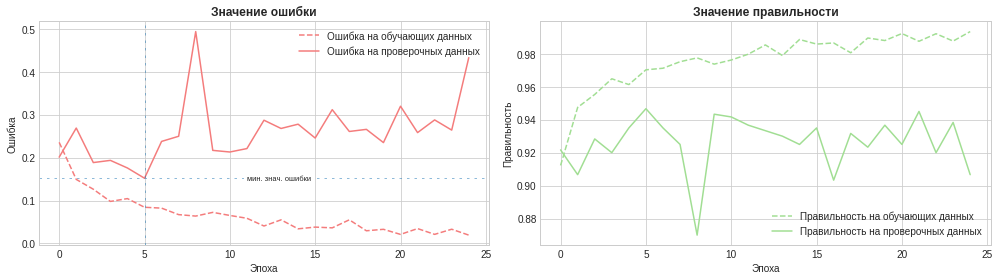

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_0.0003.csv', 'resnet', '224', 'adam', '3e-04')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
resnet18 = get_resnet18(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/resnet_224_adam_0.0003_cuda.pth')
train_preds = get_all_preds(resnet18, train_dl)
test_preds = get_all_preds(resnet18, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 4]), torch.Size([600, 4]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 16919	Train Accuracy: 95.76%
Test Correct:    570	Test Accuracy:  95.00%


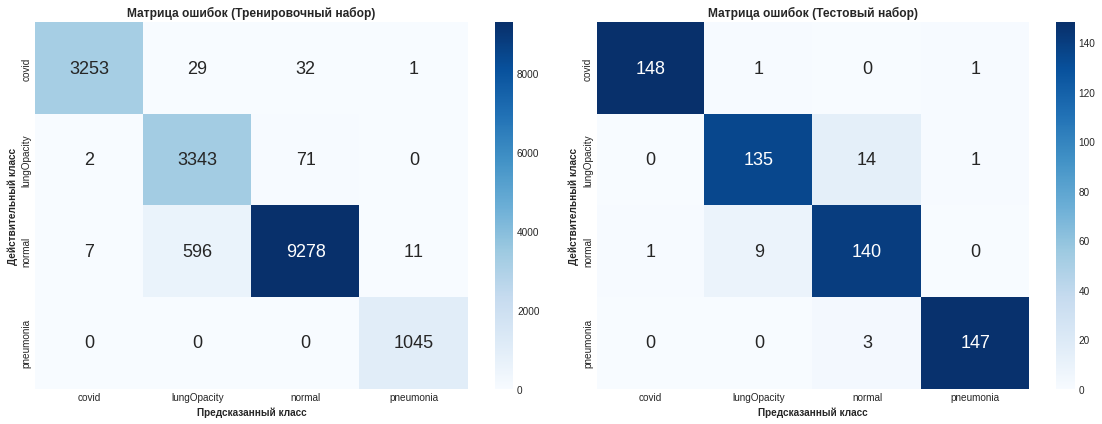

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'resnet18', '224', 'adam', '3e-04')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9947643979057592
Recall: 0.9932885906040269
Precision: 0.9866666666666667
F1-score: 0.9899665551839465
 
Class name: lungOpacity
Accuracy: 0.957983193277311
Recall: 0.9310344827586207
Precision: 0.9
F1-score: 0.9152542372881356
 
Class name: normal
Accuracy: 0.9547738693467337
Recall: 0.89171974522293
Precision: 0.9333333333333333
F1-score: 0.9120521172638437
 
Class name: pneumonia
Accuracy: 0.991304347826087
Recall: 0.9865771812080537
Precision: 0.98
F1-score: 0.9832775919732442
 


## ResNet 18 224 adam 1e-06

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet18 = get_resnet18(pretrained=True, out_features=4)

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(resnet18.parameters(), lr=1e-06)

In [ ]:
fit(
    epochs=epochs,
    model=resnet18,
    criterion=criterion,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    lr=1e-06,
    size = 224
)

Epoch [ 1/25]: 100%|██████████| 553/553 [01:02<00:00,  8.92it/s, acc=0.573, loss=1.06]



		Avg train loss: 1.034288	Avg valid loss: 0.786157

		valid_loss decreased (inf -> 0.786157)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [01:00<00:00,  9.07it/s, acc=0.8, loss=1.02]



		Avg train loss: 0.635971	Avg valid loss: 0.595510

		valid_loss decreased (0.786157 -> 0.595510)
		saving model...



Epoch [ 3/25]: 100%|██████████| 553/553 [01:00<00:00,  9.16it/s, acc=0.849, loss=0.322]



		Avg train loss: 0.474027	Avg valid loss: 0.486531

		valid_loss decreased (0.595510 -> 0.486531)
		saving model...



Epoch [ 4/25]: 100%|██████████| 553/553 [01:00<00:00,  9.19it/s, acc=0.875, loss=0.979]



		Avg train loss: 0.382996	Avg valid loss: 0.422122

		valid_loss decreased (0.486531 -> 0.422122)
		saving model...



Epoch [ 5/25]: 100%|██████████| 553/553 [01:00<00:00,  9.08it/s, acc=0.89, loss=0.982]



		Avg train loss: 0.330189	Avg valid loss: 0.377437

		valid_loss decreased (0.422122 -> 0.377437)
		saving model...



Epoch [ 6/25]: 100%|██████████| 553/553 [01:00<00:00,  9.18it/s, acc=0.903, loss=0.419]



		Avg train loss: 0.284991	Avg valid loss: 0.343133

		valid_loss decreased (0.377437 -> 0.343133)
		saving model...



Epoch [ 7/25]: 100%|██████████| 553/553 [01:00<00:00,  9.14it/s, acc=0.908, loss=0.816]



		Avg train loss: 0.266586	Avg valid loss: 0.300732

		valid_loss decreased (0.343133 -> 0.300732)
		saving model...



Epoch [ 8/25]: 100%|██████████| 553/553 [01:00<00:00,  9.15it/s, acc=0.918, loss=0.132]



		Avg train loss: 0.238506	Avg valid loss: 0.284267

		valid_loss decreased (0.300732 -> 0.284267)
		saving model...



Epoch [ 9/25]: 100%|██████████| 553/553 [01:00<00:00,  9.16it/s, acc=0.923, loss=0.68]



		Avg train loss: 0.224214	Avg valid loss: 0.272752

		valid_loss decreased (0.284267 -> 0.272752)
		saving model...



Epoch [10/25]: 100%|██████████| 553/553 [01:00<00:00,  9.18it/s, acc=0.93, loss=0.645]



		Avg train loss: 0.210521	Avg valid loss: 0.247640

		valid_loss decreased (0.272752 -> 0.247640)
		saving model...



Epoch [11/25]: 100%|██████████| 553/553 [01:00<00:00,  9.20it/s, acc=0.934, loss=1.51]



		Avg train loss: 0.193794	Avg valid loss: 0.240057

		valid_loss decreased (0.247640 -> 0.240057)
		saving model...



Epoch [12/25]: 100%|██████████| 553/553 [01:00<00:00,  9.14it/s, acc=0.94, loss=0.395]



		Avg train loss: 0.181995	Avg valid loss: 0.229017

		valid_loss decreased (0.240057 -> 0.229017)
		saving model...



Epoch [13/25]: 100%|██████████| 553/553 [01:00<00:00,  9.11it/s, acc=0.94, loss=0.762]



		Avg train loss: 0.178708	Avg valid loss: 0.216659

		valid_loss decreased (0.229017 -> 0.216659)
		saving model...



Epoch [14/25]: 100%|██████████| 553/553 [01:00<00:00,  9.15it/s, acc=0.945, loss=0.18]



		Avg train loss: 0.164797	Avg valid loss: 0.216037

		valid_loss decreased (0.216659 -> 0.216037)
		saving model...



Epoch [15/25]: 100%|██████████| 553/553 [01:00<00:00,  9.11it/s, acc=0.948, loss=0.398]



		Avg train loss: 0.157379	Avg valid loss: 0.202682

		valid_loss decreased (0.216037 -> 0.202682)
		saving model...



Epoch [16/25]: 100%|██████████| 553/553 [01:00<00:00,  9.13it/s, acc=0.947, loss=0.304]



		Avg train loss: 0.156329	Avg valid loss: 0.202452

		valid_loss decreased (0.202682 -> 0.202452)
		saving model...



Epoch [17/25]: 100%|██████████| 553/553 [01:00<00:00,  9.14it/s, acc=0.951, loss=1.03]



		Avg train loss: 0.148206	Avg valid loss: 0.204746



Epoch [18/25]: 100%|██████████| 553/553 [01:00<00:00,  9.13it/s, acc=0.954, loss=0.506]



		Avg train loss: 0.137006	Avg valid loss: 0.196156

		valid_loss decreased (0.202452 -> 0.196156)
		saving model...



Epoch [19/25]: 100%|██████████| 553/553 [01:00<00:00,  9.07it/s, acc=0.952, loss=0.36]



		Avg train loss: 0.140444	Avg valid loss: 0.193975

		valid_loss decreased (0.196156 -> 0.193975)
		saving model...



Epoch [20/25]: 100%|██████████| 553/553 [01:01<00:00,  9.06it/s, acc=0.958, loss=0.343]



		Avg train loss: 0.127458	Avg valid loss: 0.184500

		valid_loss decreased (0.193975 -> 0.184500)
		saving model...



Epoch [21/25]: 100%|██████████| 553/553 [01:00<00:00,  9.15it/s, acc=0.958, loss=0.492]



		Avg train loss: 0.119136	Avg valid loss: 0.192132



Epoch [22/25]: 100%|██████████| 553/553 [01:00<00:00,  9.13it/s, acc=0.955, loss=0.478]



		Avg train loss: 0.128605	Avg valid loss: 0.179818

		valid_loss decreased (0.184500 -> 0.179818)
		saving model...



Epoch [23/25]: 100%|██████████| 553/553 [01:00<00:00,  9.14it/s, acc=0.958, loss=0.963]



		Avg train loss: 0.123757	Avg valid loss: 0.181557



Epoch [24/25]: 100%|██████████| 553/553 [01:00<00:00,  9.16it/s, acc=0.96, loss=0.106]



		Avg train loss: 0.116169	Avg valid loss: 0.178319

		valid_loss decreased (0.179818 -> 0.178319)
		saving model...



Epoch [25/25]: 100%|██████████| 553/553 [01:00<00:00,  9.08it/s, acc=0.963, loss=0.724]



		Avg train loss: 0.111103	Avg valid loss: 0.172765

		valid_loss decreased (0.178319 -> 0.172765)
		saving model...



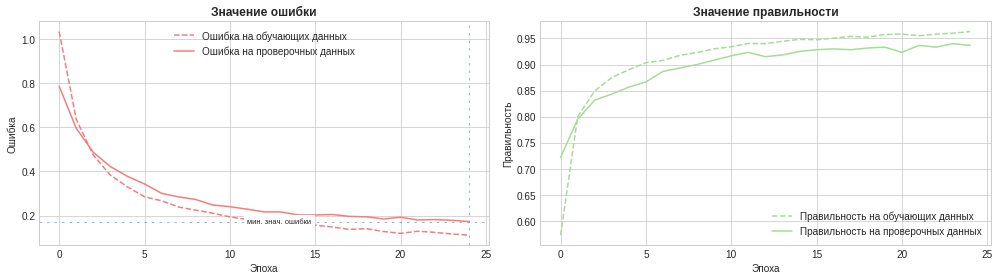

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_1e-06.csv', 'resnet', '224', 'adam', '1e-06')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
resnet18 = get_resnet18(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/resnet_224_adam_1e-06_cuda.pth')
train_preds = get_all_preds(resnet18, train_dl)
test_preds = get_all_preds(resnet18, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 4]), torch.Size([600, 4]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 16861	Train Accuracy: 95.43%
Test Correct:    558	Test Accuracy:  93.00%


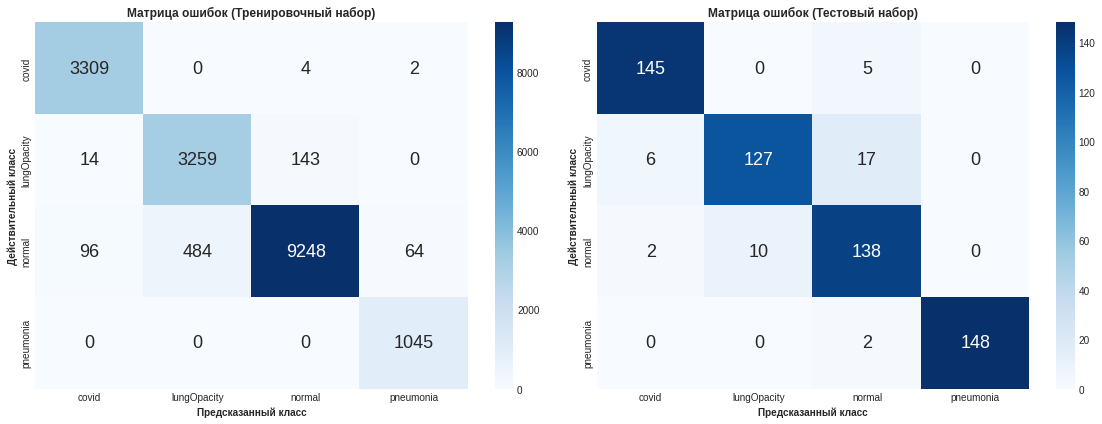

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'resnet18', '224', 'adam', '1e-06')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9772329246935202
Recall: 0.9477124183006536
Precision: 0.9666666666666667
F1-score: 0.9570957095709571
 
Class name: lungOpacity
Accuracy: 0.9441624365482234
Recall: 0.927007299270073
Precision: 0.8466666666666667
F1-score: 0.8850174216027875
 
Class name: normal
Accuracy: 0.9393939393939394
Recall: 0.8518518518518519
Precision: 0.92
F1-score: 0.8846153846153846
 
Class name: pneumonia
Accuracy: 0.9964285714285714
Recall: 1.0
Precision: 0.9866666666666667
F1-score: 0.9932885906040269
 


## ResNet 18 224 adam 3e-05

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet18 = get_resnet18(pretrained=True, out_features=4)

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(resnet18.parameters(), lr=3e-05)

In [ ]:
fit(
    epochs=epochs,
    model=resnet18,
    criterion=criterion,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    lr=3e-05,
    size = 224
)

Epoch [ 1/25]: 100%|██████████| 553/553 [03:33<00:00,  2.60it/s, acc=0.905, loss=0.0624]



		Avg train loss: 0.265441	Avg valid loss: 0.204461

		valid_loss decreased (inf -> 0.204461)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [03:34<00:00,  2.58it/s, acc=0.958, loss=0.0222]



		Avg train loss: 0.118969	Avg valid loss: 0.169418

		valid_loss decreased (0.204461 -> 0.169418)
		saving model...



Epoch [ 3/25]: 100%|██████████| 553/553 [03:36<00:00,  2.56it/s, acc=0.973, loss=0.0341]



		Avg train loss: 0.079115	Avg valid loss: 0.182437



Epoch [ 4/25]:  54%|█████▍    | 299/553 [01:57<01:39,  2.55it/s, acc=0.529, loss=0.168]

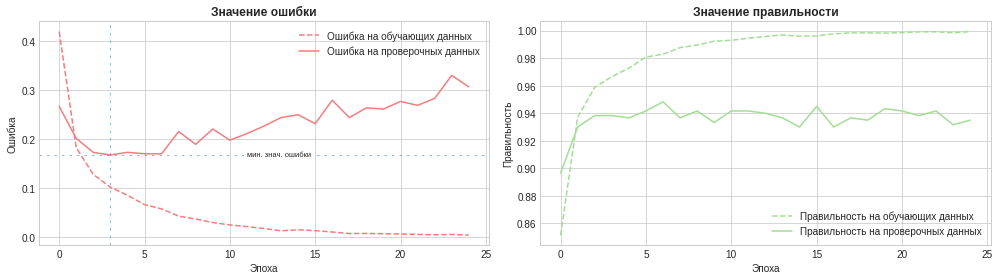

In [ ]:
plot_summary('../content/drive/MyDrive/diplom/outputs/CSVs/resnet_224_adam_1e-05.csv', 'resnet', '224', 'adam', '1e-05')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
resnet18 = get_resnet18(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/resnet_224_adam_3e-05_cuda.pth')
train_preds = get_all_preds(resnet18, train_dl)
test_preds = get_all_preds(resnet18, test_dl)

train_preds.shape, test_preds.shape

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17153	Train Accuracy: 97.03%
Test Correct:    555	Test Accuracy:  92.50%


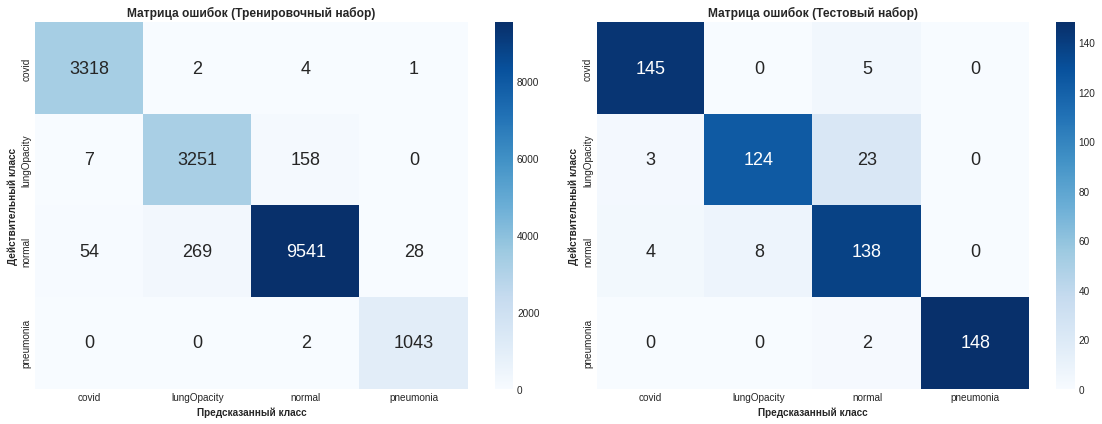

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'resnet18', '224', 'adam', '1e-05')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9894736842105263
Recall: 0.9736842105263158
Precision: 0.9866666666666667
F1-score: 0.9801324503311258
 
Class name: lungOpacity
Accuracy: 0.9510961214165261
Recall: 0.9548872180451128
Precision: 0.8466666666666667
F1-score: 0.8975265017667844
 
Class name: normal
Accuracy: 0.9431438127090301
Recall: 0.8452380952380952
Precision: 0.9466666666666667
F1-score: 0.8930817610062893
 
Class name: pneumonia
Accuracy: 0.9947089947089947
Recall: 1.0
Precision: 0.98
F1-score: 0.98989898989899
 


0.989899

## ResNet 18 224 adam cyclical_lr

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
def cyclical_lr(stepsize, min_lr=5e-06, max_lr=3e-05):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet18 = get_resnet18(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(resnet18.parameters(), lr=1.)

In [ ]:
step_size = 4*len(train_dl)

In [ ]:
lr_max = 3e-05

In [ ]:
factor = 6
end_lr = lr_max
iter=0
total_logs = []

In [ ]:
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)

In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [ ]:
fit_sheduler(
    epochs=epochs,
    model=resnet18,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dl,
    valid_dl=valid_dl,
    size=224
)

Epoch [ 1/25]: 100%|██████████| 553/553 [23:53<00:00,  2.59s/it, acc=0.83, loss=0.349]



		Avg train loss: 0.510857	Avg valid loss: 0.380601

		valid_loss decreased (inf -> 0.380601)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [10:42<00:00,  1.16s/it, acc=0.918, loss=0.875]



		Avg train loss: 0.245070	Avg valid loss: 0.250548

		valid_loss decreased (0.380601 -> 0.250548)
		saving model...



Epoch [ 3/25]: 100%|██████████| 553/553 [05:51<00:00,  1.57it/s, acc=0.94, loss=0.155]



		Avg train loss: 0.181582	Avg valid loss: 0.211679

		valid_loss decreased (0.250548 -> 0.211679)
		saving model...



Epoch [ 4/25]: 100%|██████████| 553/553 [03:49<00:00,  2.41it/s, acc=0.948, loss=1.01]



		Avg train loss: 0.149965	Avg valid loss: 0.207164

		valid_loss decreased (0.211679 -> 0.207164)
		saving model...



Epoch [ 5/25]: 100%|██████████| 553/553 [02:50<00:00,  3.24it/s, acc=0.959, loss=1.21]



		Avg train loss: 0.122794	Avg valid loss: 0.195055

		valid_loss decreased (0.207164 -> 0.195055)
		saving model...



Epoch [ 6/25]: 100%|██████████| 553/553 [02:09<00:00,  4.26it/s, acc=0.962, loss=0.966]



		Avg train loss: 0.112675	Avg valid loss: 0.185469

		valid_loss decreased (0.195055 -> 0.185469)
		saving model...



Epoch [ 7/25]: 100%|██████████| 553/553 [01:45<00:00,  5.23it/s, acc=0.968, loss=0.0214]



		Avg train loss: 0.097143	Avg valid loss: 0.174732

		valid_loss decreased (0.185469 -> 0.174732)
		saving model...



Epoch [ 8/25]: 100%|██████████| 553/553 [01:28<00:00,  6.26it/s, acc=0.972, loss=1.1]



		Avg train loss: 0.086980	Avg valid loss: 0.185226



Epoch [ 9/25]: 100%|██████████| 553/553 [01:22<00:00,  6.69it/s, acc=0.976, loss=0.101]



		Avg train loss: 0.076544	Avg valid loss: 0.191352



Epoch [10/25]: 100%|██████████| 553/553 [01:11<00:00,  7.70it/s, acc=0.979, loss=0.718]



		Avg train loss: 0.068120	Avg valid loss: 0.179208



Epoch [11/25]: 100%|██████████| 553/553 [01:07<00:00,  8.21it/s, acc=0.981, loss=0.375]



		Avg train loss: 0.060455	Avg valid loss: 0.168313

		valid_loss decreased (0.174732 -> 0.168313)
		saving model...



Epoch [12/25]: 100%|██████████| 553/553 [01:04<00:00,  8.58it/s, acc=0.983, loss=0.0858]



		Avg train loss: 0.052483	Avg valid loss: 0.158044

		valid_loss decreased (0.168313 -> 0.158044)
		saving model...



Epoch [13/25]: 100%|██████████| 553/553 [01:02<00:00,  8.81it/s, acc=0.987, loss=0.147]



		Avg train loss: 0.043778	Avg valid loss: 0.178070



Epoch [14/25]: 100%|██████████| 553/553 [01:01<00:00,  9.03it/s, acc=0.987, loss=0.0134]



		Avg train loss: 0.041520	Avg valid loss: 0.184064



Epoch [15/25]: 100%|██████████| 553/553 [01:00<00:00,  9.19it/s, acc=0.991, loss=0.108]



		Avg train loss: 0.034936	Avg valid loss: 0.197295



Epoch [16/25]: 100%|██████████| 553/553 [01:00<00:00,  9.21it/s, acc=0.992, loss=0.338]



		Avg train loss: 0.030111	Avg valid loss: 0.221688



Epoch [17/25]: 100%|██████████| 553/553 [00:59<00:00,  9.33it/s, acc=0.994, loss=0.18]



		Avg train loss: 0.025635	Avg valid loss: 0.208942



Epoch [18/25]: 100%|██████████| 553/553 [00:58<00:00,  9.40it/s, acc=0.994, loss=0.488]



		Avg train loss: 0.024610	Avg valid loss: 0.186181



Epoch [19/25]: 100%|██████████| 553/553 [00:59<00:00,  9.31it/s, acc=0.995, loss=0.148]



		Avg train loss: 0.020455	Avg valid loss: 0.192966



Epoch [20/25]: 100%|██████████| 553/553 [00:59<00:00,  9.26it/s, acc=0.997, loss=0.477]



		Avg train loss: 0.016193	Avg valid loss: 0.254713



Epoch [21/25]: 100%|██████████| 553/553 [00:59<00:00,  9.34it/s, acc=0.996, loss=1.79]



		Avg train loss: 0.017272	Avg valid loss: 0.227341



Epoch [22/25]: 100%|██████████| 553/553 [00:59<00:00,  9.35it/s, acc=0.997, loss=0.092]



		Avg train loss: 0.014489	Avg valid loss: 0.219397



Epoch [23/25]: 100%|██████████| 553/553 [00:58<00:00,  9.43it/s, acc=0.997, loss=0.0489]



		Avg train loss: 0.013033	Avg valid loss: 0.228534



Epoch [24/25]: 100%|██████████| 553/553 [00:59<00:00,  9.35it/s, acc=0.998, loss=1.11]



		Avg train loss: 0.011953	Avg valid loss: 0.229523



Epoch [25/25]: 100%|██████████| 553/553 [00:58<00:00,  9.43it/s, acc=0.998, loss=0.349]



		Avg train loss: 0.010574	Avg valid loss: 0.222455



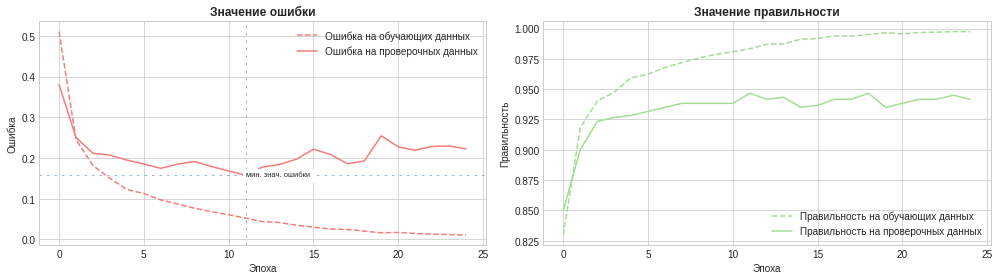

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_lambdalr.csv', 'resnet', '224', 'adam', 'lambdalr')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
resnet18 = get_resnet18(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/resnet_224_adam_lambdalr_cuda.pth')
train_preds = get_all_preds(resnet18, train_dl)
test_preds = get_all_preds(resnet18, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 4]), torch.Size([600, 4]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17359	Train Accuracy: 98.25%
Test Correct:    571	Test Accuracy:  95.17%


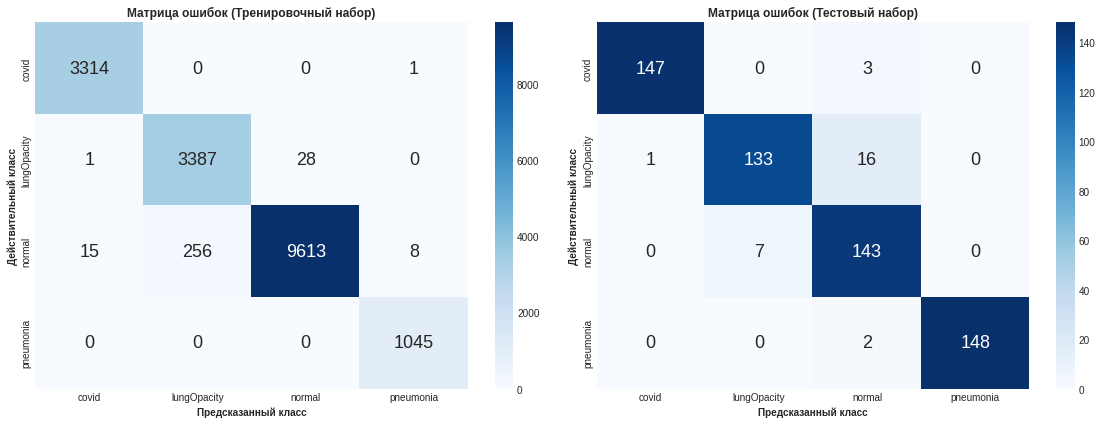

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'resnet', '224', 'adam', 'lambdalr')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9930434782608696
Recall: 0.9932432432432432
Precision: 0.98
F1-score: 0.9865771812080537
 
Class name: lungOpacity
Accuracy: 0.9596638655462185
Recall: 0.95
Precision: 0.8866666666666667
F1-score: 0.9172413793103449
 
Class name: normal
Accuracy: 0.9532554257095158
Recall: 0.8719512195121951
Precision: 0.9533333333333334
F1-score: 0.9108280254777071
 
Class name: pneumonia
Accuracy: 0.9965095986038395
Recall: 1.0
Precision: 0.9866666666666667
F1-score: 0.9932885906040269
 


In [ ]:
round(0.9932885906040269, 6)

0.993289

In [ ]:
round(0.9932432432432432, 6)
round(0.98, 6)
round(0.9865771812080537, 6)
 
round(0.9596638655462185, 6)
round(0.95, 6)
round(0.8866666666666667, 6)
round(0.9172413793103449, 6)

round(0.9532554257095158, 6)
round(0.8719512195121951, 6)
round(0.9533333333333334, 6)
round(0.9108280254777071, 6)
 
round(0.9965095986038395, 6)
round(1.0, 6)
round(0.9866666666666667, 6)
round(0.9932885906040269, 6)

## Сравнение ошибки

In [45]:
path1 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_1e-06.csv'
path2 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_3e-04.csv'
path3 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_3e-05.csv'
path4 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_lambdalr.csv'

In [46]:
data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)
data4 = pd.read_csv(path4)

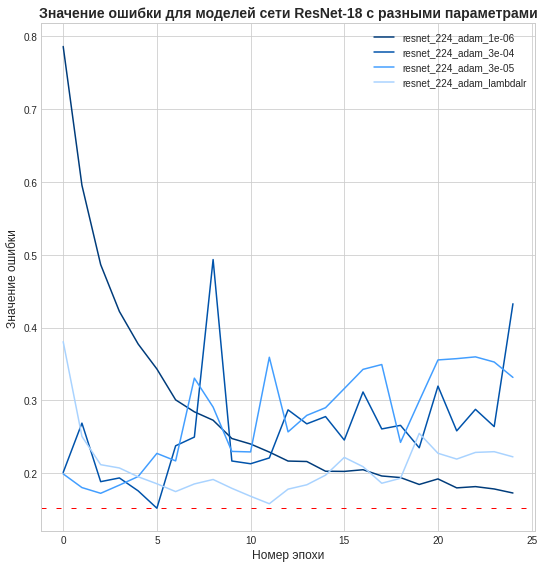

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_loss'], label='resnet_224_adam_1e-06', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_loss'], label='resnet_224_adam_3e-04', color="#0053AB")
ax.plot(data3['epoch'], data3['valid_loss'], label='resnet_224_adam_3e-05', color="#429EFF")
ax.plot(data4['epoch'], data4['valid_loss'], label='resnet_224_adam_lambdalr', color="#A9D3FF")
ax.axhline(min(min(data1['valid_loss']), min(data2['valid_loss']), min(data3['valid_loss']), min(data4['valid_loss'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend()
ax.set_title('Значение ошибки для моделей сети ResNet-18 с разными параметрами', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение ошибки', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/resnet_224_adam_loss_comparison.png')
plt.show()
plt.close()

## Сравнение правильность

In [48]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_acc'], label='ResNet-18: 1x10^-6', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_acc'], label='ResNet-18: 3x10^-4', color="#0053AB")
ax.plot(data3['epoch'], data3['valid_acc'], label='ResNet-18: 3x10^-5', color="#429EFF")
ax.plot(data4['epoch'], data4['valid_acc'], label='ResNet-18: [5x10^-6; 3x10^-5]', color="#A9D3FF")
ax.set_ylim(0.7, 1)
ax.axhline(max(max(data1['valid_acc']), max(data2['valid_acc']), max(data3['valid_acc']), max(data4['valid_acc'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend(loc ='lower right', fontsize=12)
ax.set_title('Значение правильности для моделей сети ResNet-18\nс разными параметрами скорости обучения', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение правильности', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/resnet_224_adam_acc_comparison.pdf')
plt.show()
plt.close()

# DenseNet

## DenseNet121 224 adam 9.5e-05

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
densenet121 = get_densenet121(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(densenet121.parameters(), lr=9.5e-05)

In [ ]:
fit(
    epochs=epochs,
    model=densenet121,
    criterion=criterion,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    lr=9.5e-05,
    size = 224
)

Epoch [ 1/25]: 100%|██████████| 553/553 [04:09<00:00,  2.22it/s, acc=0.906, loss=2.3]



		Avg train loss: 0.426607	Avg valid loss: 0.192845

		valid_loss decreased (inf -> 0.192845)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [02:50<00:00,  3.25it/s, acc=0.959, loss=0.492]



		Avg train loss: 0.114566	Avg valid loss: 0.211186



Epoch [ 3/25]: 100%|██████████| 553/553 [03:28<00:00,  2.65it/s, acc=0.972, loss=0.0342]



		Avg train loss: 0.082771	Avg valid loss: 0.160196

		valid_loss decreased (0.192845 -> 0.160196)
		saving model...



Epoch [ 4/25]: 100%|██████████| 553/553 [03:15<00:00,  2.83it/s, acc=0.976, loss=0.663]



		Avg train loss: 0.068853	Avg valid loss: 0.278425



Epoch [ 5/25]: 100%|██████████| 553/553 [03:17<00:00,  2.80it/s, acc=0.973, loss=0.846]



		Avg train loss: 0.071081	Avg valid loss: 0.253835



Epoch [ 6/25]: 100%|██████████| 553/553 [03:35<00:00,  2.57it/s, acc=0.98, loss=1.01]



		Avg train loss: 0.058317	Avg valid loss: 0.314772



Epoch [ 7/25]: 100%|██████████| 553/553 [02:50<00:00,  3.25it/s, acc=0.981, loss=0.0932]



		Avg train loss: 0.051442	Avg valid loss: 0.187886



Epoch [ 8/25]: 100%|██████████| 553/553 [02:49<00:00,  3.25it/s, acc=0.984, loss=2.87]



		Avg train loss: 0.044612	Avg valid loss: 0.218058



Epoch [ 9/25]: 100%|██████████| 553/553 [02:49<00:00,  3.25it/s, acc=0.98, loss=0.000428]



		Avg train loss: 0.052574	Avg valid loss: 0.229181



Epoch [10/25]: 100%|██████████| 553/553 [02:49<00:00,  3.27it/s, acc=0.989, loss=0.109]



		Avg train loss: 0.030521	Avg valid loss: 0.264119



Epoch [11/25]: 100%|██████████| 553/553 [03:08<00:00,  2.93it/s, acc=0.987, loss=0.0276]



		Avg train loss: 0.036788	Avg valid loss: 0.246261



Epoch [12/25]: 100%|██████████| 553/553 [03:10<00:00,  2.90it/s, acc=0.989, loss=0.455]



		Avg train loss: 0.029053	Avg valid loss: 0.263458



Epoch [13/25]: 100%|██████████| 553/553 [02:49<00:00,  3.26it/s, acc=0.987, loss=1.03]



		Avg train loss: 0.035183	Avg valid loss: 0.241319



Epoch [14/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.986, loss=0.0683]



		Avg train loss: 0.036878	Avg valid loss: 0.332301



Epoch [15/25]: 100%|██████████| 553/553 [02:47<00:00,  3.29it/s, acc=0.993, loss=8.55e-6]



		Avg train loss: 0.019879	Avg valid loss: 0.245803



Epoch [16/25]: 100%|██████████| 553/553 [02:47<00:00,  3.31it/s, acc=0.992, loss=0.013]



		Avg train loss: 0.021039	Avg valid loss: 0.278570



Epoch [17/25]: 100%|██████████| 553/553 [02:47<00:00,  3.29it/s, acc=0.992, loss=0.724]



		Avg train loss: 0.020292	Avg valid loss: 0.291272



Epoch [18/25]: 100%|██████████| 553/553 [02:48<00:00,  3.29it/s, acc=0.988, loss=0.154]



		Avg train loss: 0.032672	Avg valid loss: 0.268640



Epoch [19/25]: 100%|██████████| 553/553 [02:47<00:00,  3.31it/s, acc=0.993, loss=0.000143]



		Avg train loss: 0.017872	Avg valid loss: 0.343811



Epoch [20/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.993, loss=0.000834]



		Avg train loss: 0.018873	Avg valid loss: 0.328946



Epoch [21/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.994, loss=0.00186]



		Avg train loss: 0.017454	Avg valid loss: 0.297037



Epoch [22/25]: 100%|██████████| 553/553 [02:50<00:00,  3.25it/s, acc=0.992, loss=0.000108]



		Avg train loss: 0.019930	Avg valid loss: 0.351379



Epoch [23/25]: 100%|██████████| 553/553 [02:51<00:00,  3.23it/s, acc=0.993, loss=0.31]



		Avg train loss: 0.016837	Avg valid loss: 0.317865



Epoch [24/25]: 100%|██████████| 553/553 [02:50<00:00,  3.24it/s, acc=0.992, loss=1.9e-5]



		Avg train loss: 0.022768	Avg valid loss: 0.288158



Epoch [25/25]: 100%|██████████| 553/553 [02:50<00:00,  3.25it/s, acc=0.994, loss=0.00048]



		Avg train loss: 0.014922	Avg valid loss: 0.307834



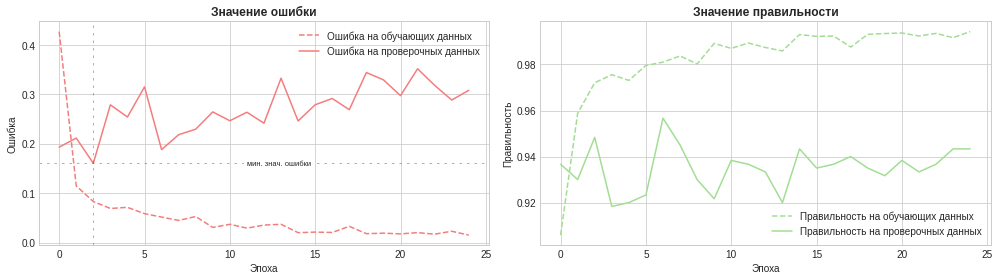

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_9.5e-05.csv', 'densenet', '224', 'adam', '9.5e-05')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
densenet121 = get_densenet121(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/densenet_224_adam_2e-05_cuda.pth')
train_preds = get_all_preds(densenet121, train_dl)
test_preds = get_all_preds(densenet121, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17243	Train Accuracy: 97.59%
Test Correct:    570	Test Accuracy:  95.00%


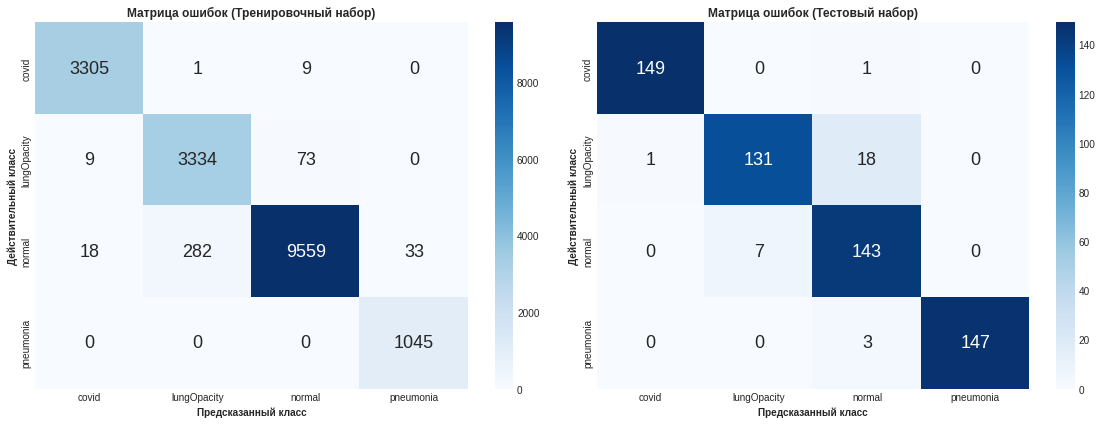

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'densenet', '224', 'adam', '2e-05')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9965034965034965
Recall: 0.9933333333333333
Precision: 0.9933333333333333
F1-score: 0.9933333333333333
 
Class name: lungOpacity
Accuracy: 0.9563758389261745
Recall: 0.9492753623188406
Precision: 0.8733333333333333
F1-score: 0.9097222222222222
 
Class name: normal
Accuracy: 0.9515859766277128
Recall: 0.8666666666666667
Precision: 0.9533333333333334
F1-score: 0.907936507936508
 
Class name: pneumonia
Accuracy: 0.9947643979057592
Recall: 1.0
Precision: 0.98
F1-score: 0.98989898989899
 


0.989899

In [ ]:
0.9965034965034965
0.9933333333333333
0.9933333333333333
0.9933333333333333

0.9563758389261745
0.9492753623188406
0.8733333333333333
0.9097222222222222

0.9515859766277128
0.8666666666666667
0.9533333333333334
0.907936507936508

0.9947643979057592
1.0
0.98
0.98989898989899

## DenseNet121 224 adam 1e-06

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
densenet121 = get_densenet121(pretrained=True, out_features=4)

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(densenet121.parameters(), lr=1e-06)

In [ ]:
fit(
    epochs=epochs,
    model=densenet121,
    criterion=criterion,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    lr=1e-06,
    size = 224
)

Epoch [ 1/25]: 100%|██████████| 553/553 [02:54<00:00,  3.17it/s, acc=0.0402, loss=6.22]



		Avg train loss: 7.297531	Avg valid loss: 5.893678

		valid_loss decreased (inf -> 5.893678)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.339, loss=2.76]



		Avg train loss: 4.395649	Avg valid loss: 3.551629

		valid_loss decreased (5.893678 -> 3.551629)
		saving model...



Epoch [ 3/25]: 100%|██████████| 553/553 [02:46<00:00,  3.33it/s, acc=0.664, loss=6.04]



		Avg train loss: 2.523894	Avg valid loss: 2.106662

		valid_loss decreased (3.551629 -> 2.106662)
		saving model...



Epoch [ 4/25]: 100%|██████████| 553/553 [02:46<00:00,  3.32it/s, acc=0.788, loss=1.75]



		Avg train loss: 1.575102	Avg valid loss: 1.375013

		valid_loss decreased (2.106662 -> 1.375013)
		saving model...



Epoch [ 5/25]: 100%|██████████| 553/553 [02:46<00:00,  3.32it/s, acc=0.825, loss=1.52]



		Avg train loss: 1.178268	Avg valid loss: 1.029195

		valid_loss decreased (1.375013 -> 1.029195)
		saving model...



Epoch [ 6/25]: 100%|██████████| 553/553 [02:47<00:00,  3.31it/s, acc=0.855, loss=5.44]



		Avg train loss: 0.860313	Avg valid loss: 0.825218

		valid_loss decreased (1.029195 -> 0.825218)
		saving model...



Epoch [ 7/25]: 100%|██████████| 553/553 [02:46<00:00,  3.32it/s, acc=0.875, loss=0.604]



		Avg train loss: 0.698435	Avg valid loss: 0.648077

		valid_loss decreased (0.825218 -> 0.648077)
		saving model...



Epoch [ 8/25]: 100%|██████████| 553/553 [02:47<00:00,  3.31it/s, acc=0.889, loss=10.1]



		Avg train loss: 0.568696	Avg valid loss: 0.574147

		valid_loss decreased (0.648077 -> 0.574147)
		saving model...



Epoch [ 9/25]: 100%|██████████| 553/553 [02:47<00:00,  3.31it/s, acc=0.898, loss=0.0733]



		Avg train loss: 0.484355	Avg valid loss: 0.472297

		valid_loss decreased (0.574147 -> 0.472297)
		saving model...



Epoch [10/25]: 100%|██████████| 553/553 [02:48<00:00,  3.29it/s, acc=0.906, loss=0.457]



		Avg train loss: 0.408230	Avg valid loss: 0.434266

		valid_loss decreased (0.472297 -> 0.434266)
		saving model...



Epoch [11/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.916, loss=3.76]



		Avg train loss: 0.348436	Avg valid loss: 0.391135

		valid_loss decreased (0.434266 -> 0.391135)
		saving model...



Epoch [12/25]: 100%|██████████| 553/553 [02:48<00:00,  3.27it/s, acc=0.916, loss=2.22]



		Avg train loss: 0.331292	Avg valid loss: 0.358832

		valid_loss decreased (0.391135 -> 0.358832)
		saving model...



Epoch [13/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.923, loss=1.36]



		Avg train loss: 0.291126	Avg valid loss: 0.353344

		valid_loss decreased (0.358832 -> 0.353344)
		saving model...



Epoch [14/25]: 100%|██████████| 553/553 [02:48<00:00,  3.29it/s, acc=0.928, loss=1.01]



		Avg train loss: 0.261004	Avg valid loss: 0.309934

		valid_loss decreased (0.353344 -> 0.309934)
		saving model...



Epoch [15/25]: 100%|██████████| 553/553 [02:48<00:00,  3.29it/s, acc=0.929, loss=0.0123]



		Avg train loss: 0.247197	Avg valid loss: 0.291146

		valid_loss decreased (0.309934 -> 0.291146)
		saving model...



Epoch [16/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.935, loss=0.533]



		Avg train loss: 0.223343	Avg valid loss: 0.277692

		valid_loss decreased (0.291146 -> 0.277692)
		saving model...



Epoch [17/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.939, loss=1.96]



		Avg train loss: 0.207886	Avg valid loss: 0.270539

		valid_loss decreased (0.277692 -> 0.270539)
		saving model...



Epoch [18/25]: 100%|██████████| 553/553 [02:47<00:00,  3.29it/s, acc=0.941, loss=0.445]



		Avg train loss: 0.194878	Avg valid loss: 0.261988

		valid_loss decreased (0.270539 -> 0.261988)
		saving model...



Epoch [19/25]: 100%|██████████| 553/553 [02:47<00:00,  3.29it/s, acc=0.943, loss=0.0536]



		Avg train loss: 0.184776	Avg valid loss: 0.256330

		valid_loss decreased (0.261988 -> 0.256330)
		saving model...



Epoch [20/25]: 100%|██████████| 553/553 [02:49<00:00,  3.27it/s, acc=0.944, loss=1.62]



		Avg train loss: 0.175053	Avg valid loss: 0.264360



Epoch [21/25]: 100%|██████████| 553/553 [02:49<00:00,  3.25it/s, acc=0.948, loss=0.0787]



		Avg train loss: 0.166915	Avg valid loss: 0.243697

		valid_loss decreased (0.256330 -> 0.243697)
		saving model...



Epoch [22/25]: 100%|██████████| 553/553 [02:50<00:00,  3.24it/s, acc=0.951, loss=0.0591]



		Avg train loss: 0.152777	Avg valid loss: 0.234319

		valid_loss decreased (0.243697 -> 0.234319)
		saving model...



Epoch [23/25]: 100%|██████████| 553/553 [02:50<00:00,  3.24it/s, acc=0.952, loss=0.554]



		Avg train loss: 0.144798	Avg valid loss: 0.239669



Epoch [24/25]: 100%|██████████| 553/553 [02:50<00:00,  3.25it/s, acc=0.953, loss=0.0392]



		Avg train loss: 0.141845	Avg valid loss: 0.212982

		valid_loss decreased (0.234319 -> 0.212982)
		saving model...



Epoch [25/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.955, loss=0.024]



		Avg train loss: 0.134774	Avg valid loss: 0.239175



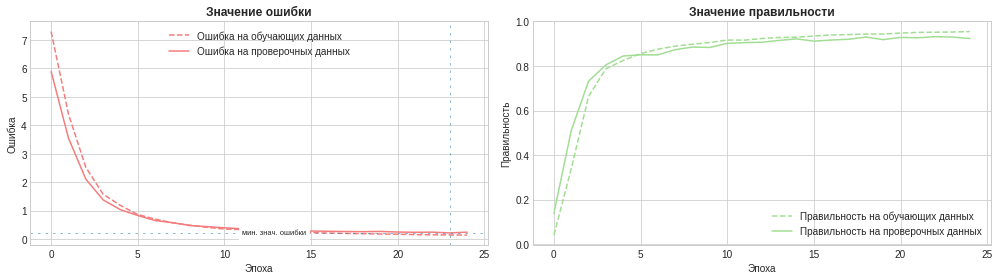

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_1e-06.csv', 'densenet', '224', 'adam', '1e-06')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
densenet121 = get_densenet121(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/densenet_224_adam_1e-06_cuda.pth')
train_preds = get_all_preds(densenet121, train_dl)
test_preds = get_all_preds(densenet121, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 16889	Train Accuracy: 95.59%
Test Correct:    567	Test Accuracy:  94.50%


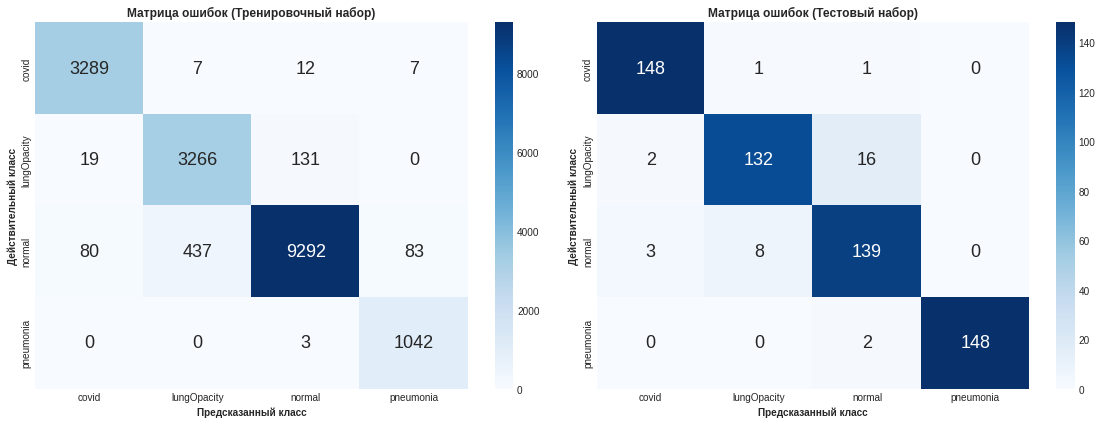

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'densenet', '224', 'adam', '1e-06')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9878048780487805
Recall: 0.9673202614379085
Precision: 0.9866666666666667
F1-score: 0.9768976897689768
 
Class name: lungOpacity
Accuracy: 0.9545454545454546
Recall: 0.9361702127659575
Precision: 0.88
F1-score: 0.9072164948453608
 
Class name: normal
Accuracy: 0.949748743718593
Recall: 0.879746835443038
Precision: 0.9266666666666666
F1-score: 0.9025974025974027
 
Class name: pneumonia
Accuracy: 0.9964850615114236
Recall: 1.0
Precision: 0.9866666666666667
F1-score: 0.9932885906040269
 


0.993289

In [ ]:
0.9878048780487805
0.9673202614379085
0.9866666666666667
0.9768976897689768
 
0.9545454545454546
0.9361702127659575
 0.88
0.9072164948453608
 
0.949748743718593
0.879746835443038
 0.9266666666666666
0.9025974025974027
 
0.9964850615114236
1.0
 0.9866666666666667
0.9932885906040269

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
densenet121 = get_densenet121(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/densenet_224_adam_3e-05_cuda.pth')
train_preds = get_all_preds(densenet121, train_dl)
test_preds = get_all_preds(densenet121, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17079	Train Accuracy: 96.67%
Test Correct:    571	Test Accuracy:  95.17%


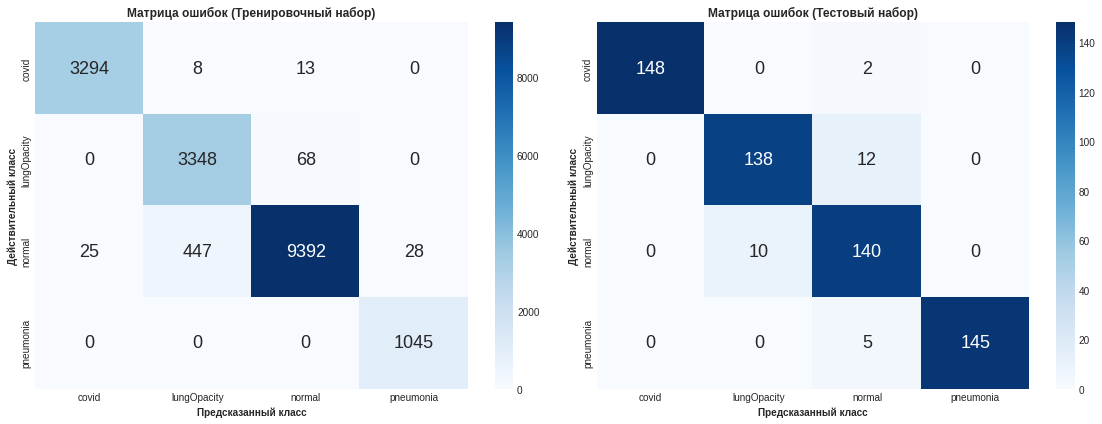

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'densenet', '224', 'adam', '3e-05')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9965095986038395
Recall: 1.0
Precision: 0.9866666666666667
F1-score: 0.9932885906040269
 
Class name: lungOpacity
Accuracy: 0.9629005059021922
Recall: 0.9324324324324325
Precision: 0.92
F1-score: 0.9261744966442953
 
Class name: normal
Accuracy: 0.9516666666666667
Recall: 0.8805031446540881
Precision: 0.9333333333333333
F1-score: 0.9061488673139159
 
Class name: pneumonia
Accuracy: 0.9913194444444444
Recall: 1.0
Precision: 0.9666666666666667
F1-score: 0.983050847457627
 


0.983051

In [ ]:
0.9965095986038395
1.0
0.9866666666666667
0.9932885906040269

0.9629005059021922
0.9324324324324325
0.92
0.9261744966442953
 
0.9516666666666667
0.8805031446540881
0.9333333333333333
0.9061488673139159
 
0.9913194444444444
1.0
0.9666666666666667
0.983050847457627

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
densenet121 = get_densenet121(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/densenet_224_adam_9.5e-05_cuda.pth')
train_preds = get_all_preds(densenet121, train_dl)
test_preds = get_all_preds(densenet121, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17017	Train Accuracy: 96.32%
Test Correct:    576	Test Accuracy:  96.00%


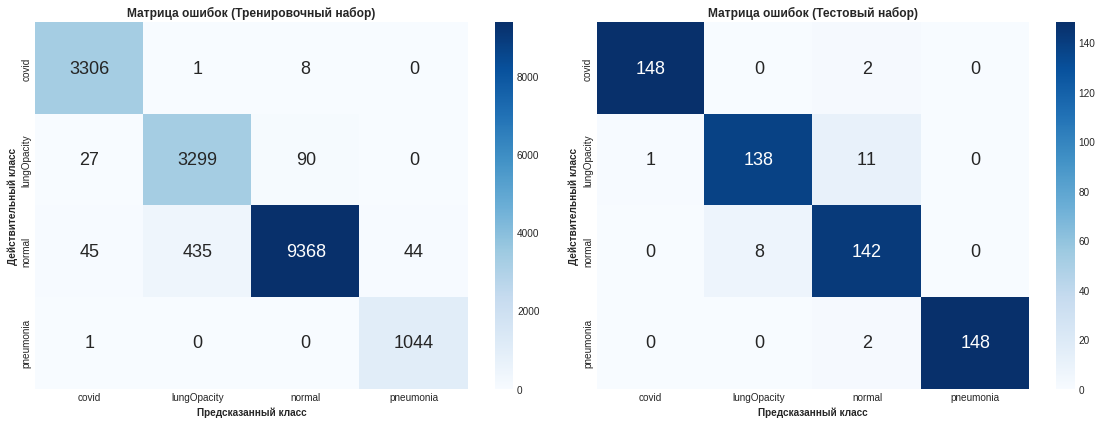

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'densenet', '224', 'adam', '9.5e-05')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9948186528497409
Recall: 0.9932885906040269
Precision: 0.9866666666666667
F1-score: 0.9899665551839465
 
Class name: lungOpacity
Accuracy: 0.9664429530201343
Recall: 0.9452054794520548
Precision: 0.92
F1-score: 0.9324324324324323
 
Class name: normal
Accuracy: 0.9616026711185309
Recall: 0.9044585987261147
Precision: 0.9466666666666667
F1-score: 0.9250814332247558
 
Class name: pneumonia
Accuracy: 0.9965397923875432
Recall: 1.0
Precision: 0.9866666666666667
F1-score: 0.9932885906040269
 


## DenseNet121 224 adam cyclical_lr

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
def cyclical_lr(stepsize, min_lr=1.5e-06, max_lr=9e-06):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
densenet121 = get_densenet121(pretrained=True, out_features=4)

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(densenet121.parameters(), lr=1.)

In [ ]:
step_size = 4*len(train_dl)

In [ ]:
lr_max = 9e-06

In [ ]:
factor = 6
end_lr = lr_max
iter=0
total_logs = []

In [ ]:
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)

In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [ ]:
fit_sheduler(
    epochs=epochs,
    model=densenet121,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dl,
    valid_dl=valid_dl,
    size=224
)

Epoch [ 1/25]: 100%|██████████| 553/553 [02:50<00:00,  3.25it/s, acc=0.106, loss=5.19]



		Avg train loss: 6.544135	Avg valid loss: 4.577233

		valid_loss decreased (inf -> 4.577233)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [02:51<00:00,  3.23it/s, acc=0.59, loss=1.62]



		Avg train loss: 2.936017	Avg valid loss: 2.234369

		valid_loss decreased (4.577233 -> 2.234369)
		saving model...



Epoch [ 3/25]: 100%|██████████| 553/553 [02:51<00:00,  3.23it/s, acc=0.797, loss=4.56]



		Avg train loss: 1.496914	Avg valid loss: 1.238154

		valid_loss decreased (2.234369 -> 1.238154)
		saving model...



Epoch [ 4/25]: 100%|██████████| 553/553 [02:50<00:00,  3.24it/s, acc=0.847, loss=0.98]



		Avg train loss: 0.923664	Avg valid loss: 0.800959

		valid_loss decreased (1.238154 -> 0.800959)
		saving model...



Epoch [ 5/25]: 100%|██████████| 553/553 [02:49<00:00,  3.25it/s, acc=0.873, loss=1.23]



		Avg train loss: 0.689207	Avg valid loss: 0.620294

		valid_loss decreased (0.800959 -> 0.620294)
		saving model...



Epoch [ 6/25]: 100%|██████████| 553/553 [02:47<00:00,  3.31it/s, acc=0.893, loss=5.17]



		Avg train loss: 0.507407	Avg valid loss: 0.492873

		valid_loss decreased (0.620294 -> 0.492873)
		saving model...



Epoch [ 7/25]: 100%|██████████| 553/553 [02:47<00:00,  3.31it/s, acc=0.904, loss=0.292]



		Avg train loss: 0.426109	Avg valid loss: 0.410887

		valid_loss decreased (0.492873 -> 0.410887)
		saving model...



Epoch [ 8/25]: 100%|██████████| 553/553 [02:48<00:00,  3.29it/s, acc=0.914, loss=9.83]



		Avg train loss: 0.351507	Avg valid loss: 0.366275

		valid_loss decreased (0.410887 -> 0.366275)
		saving model...



Epoch [ 9/25]: 100%|██████████| 553/553 [02:50<00:00,  3.25it/s, acc=0.921, loss=0.0395]



		Avg train loss: 0.311171	Avg valid loss: 0.323803

		valid_loss decreased (0.366275 -> 0.323803)
		saving model...



Epoch [10/25]: 100%|██████████| 553/553 [02:49<00:00,  3.27it/s, acc=0.928, loss=0.475]



		Avg train loss: 0.264579	Avg valid loss: 0.314604

		valid_loss decreased (0.323803 -> 0.314604)
		saving model...



Epoch [11/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.935, loss=3.54]



		Avg train loss: 0.229820	Avg valid loss: 0.287744

		valid_loss decreased (0.314604 -> 0.287744)
		saving model...



Epoch [12/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.935, loss=2.01]



		Avg train loss: 0.219373	Avg valid loss: 0.268259

		valid_loss decreased (0.287744 -> 0.268259)
		saving model...



Epoch [13/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.94, loss=1.47]



		Avg train loss: 0.194058	Avg valid loss: 0.271823



Epoch [14/25]: 100%|██████████| 553/553 [02:47<00:00,  3.31it/s, acc=0.946, loss=0.672]



		Avg train loss: 0.174591	Avg valid loss: 0.242484

		valid_loss decreased (0.268259 -> 0.242484)
		saving model...



Epoch [15/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.949, loss=0.00935]



		Avg train loss: 0.163647	Avg valid loss: 0.233649

		valid_loss decreased (0.242484 -> 0.233649)
		saving model...



Epoch [16/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.951, loss=0.46]



		Avg train loss: 0.152009	Avg valid loss: 0.227383

		valid_loss decreased (0.233649 -> 0.227383)
		saving model...



Epoch [17/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.954, loss=1.7]



		Avg train loss: 0.140726	Avg valid loss: 0.217177

		valid_loss decreased (0.227383 -> 0.217177)
		saving model...



Epoch [18/25]: 100%|██████████| 553/553 [02:49<00:00,  3.26it/s, acc=0.957, loss=0.482]



		Avg train loss: 0.130698	Avg valid loss: 0.218500



Epoch [19/25]: 100%|██████████| 553/553 [02:49<00:00,  3.27it/s, acc=0.959, loss=0.0286]



		Avg train loss: 0.122240	Avg valid loss: 0.219270



Epoch [20/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.961, loss=1.3]



		Avg train loss: 0.116176	Avg valid loss: 0.233434



Epoch [21/25]: 100%|██████████| 553/553 [02:48<00:00,  3.28it/s, acc=0.963, loss=0.117]



		Avg train loss: 0.110343	Avg valid loss: 0.221589



Epoch [22/25]: 100%|██████████| 553/553 [02:48<00:00,  3.29it/s, acc=0.966, loss=0.0195]



		Avg train loss: 0.098945	Avg valid loss: 0.204259

		valid_loss decreased (0.217177 -> 0.204259)
		saving model...



Epoch [23/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.969, loss=0.241]



		Avg train loss: 0.093535	Avg valid loss: 0.219442



Epoch [24/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.971, loss=0.0208]



		Avg train loss: 0.089512	Avg valid loss: 0.196076

		valid_loss decreased (0.204259 -> 0.196076)
		saving model...



Epoch [25/25]: 100%|██████████| 553/553 [02:47<00:00,  3.30it/s, acc=0.971, loss=0.0111]



		Avg train loss: 0.086039	Avg valid loss: 0.229204



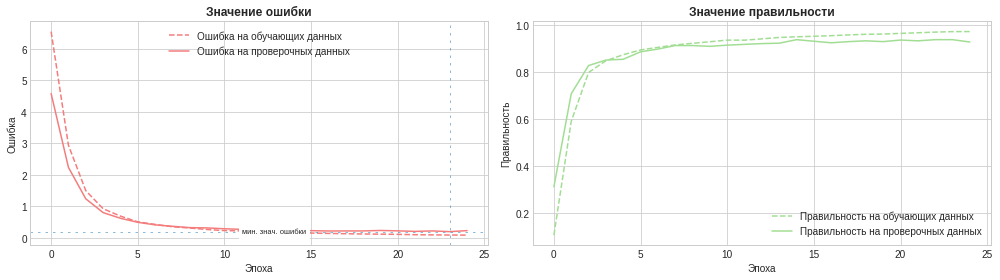

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_lambdalr.csv', 'densenet', '224', 'adam', 'lambdalr')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
densenet = get_densenet121(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/densenet_224_adam_lambdalr_cuda.pth')
train_preds = get_all_preds(densenet, train_dl)
test_preds = get_all_preds(densenet, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17179	Train Accuracy: 97.23%
Test Correct:    565	Test Accuracy:  94.17%


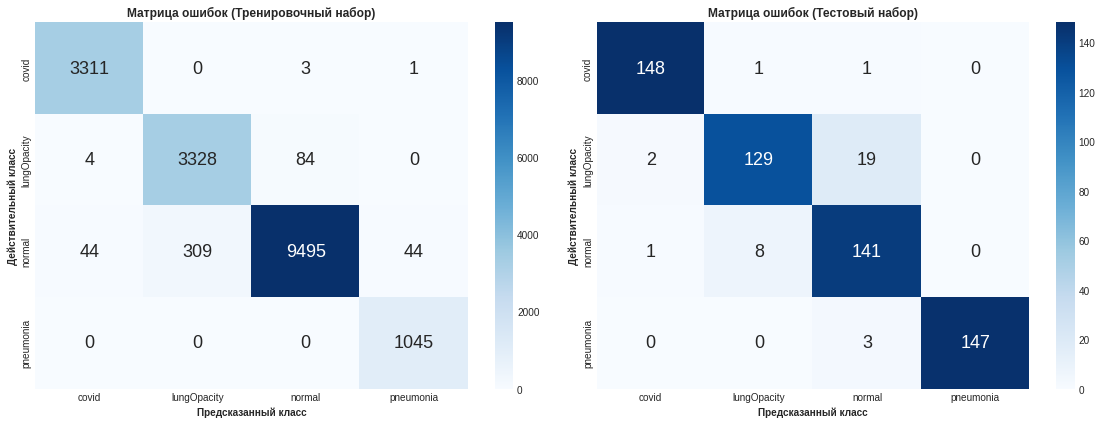

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'densenet', '224', 'adam', 'lambdalr')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9912280701754386
Recall: 0.9801324503311258
Precision: 0.9866666666666667
F1-score: 0.983388704318937
 
Class name: lungOpacity
Accuracy: 0.9495798319327731
Recall: 0.9347826086956522
Precision: 0.86
F1-score: 0.8958333333333334
 
Class name: normal
Accuracy: 0.9463986599664992
Recall: 0.8597560975609756
Precision: 0.94
F1-score: 0.8980891719745222
 
Class name: pneumonia
Accuracy: 0.9947183098591549
Recall: 1.0
Precision: 0.98
F1-score: 0.98989898989899
 


## Сравнение ошибки

In [49]:
path1 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_1e-06.csv'
path2 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_9.5e-05.csv'
path3 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_9e-06.csv'
path4 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_lambdalr.csv'

In [50]:
data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)
data4 = pd.read_csv(path4)

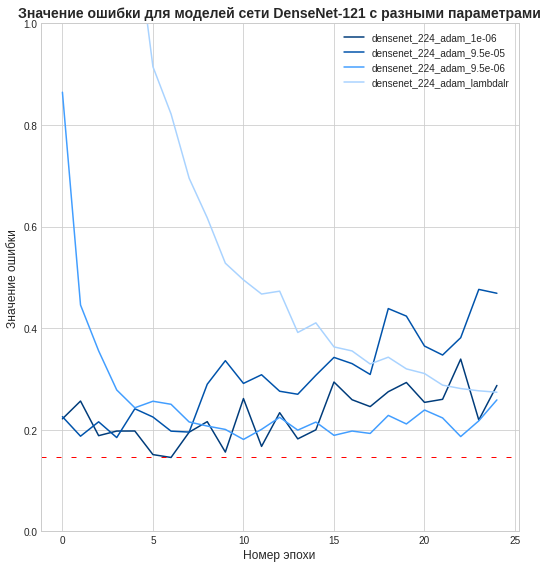

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_loss'], label='densenet_224_adam_1e-06', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_loss'], label='densenet_224_adam_9.5e-05', color="#0053AB")
ax.plot(data3['epoch'], data3['valid_loss'], label='densenet_224_adam_9.5e-06', color="#429EFF")
ax.plot(data4['epoch'], data4['valid_loss'], label='densenet_224_adam_lambdalr', color="#A9D3FF")
ax.set_ylim(0, 1)
ax.axhline(min(min(data1['valid_loss']), min(data2['valid_loss']), min(data3['valid_loss']), min(data4['valid_loss'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend()
ax.set_title('Значение ошибки для моделей сети DenseNet-121 с разными параметрами', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение ошибки', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/densenet_224_adam_loss_comparison.png')
plt.show()
plt.close()

## Сравнение правильность

In [51]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_acc'], label='DenseNet-121: 1x10^-6', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_acc'], label='DenseNet-121: 9.5x10^-5', color="#0053AB")
ax.plot(data3['epoch'], data3['valid_acc'], label='DenseNet-121: 9.5x10^-6', color="#429EFF")
ax.plot(data4['epoch'], data4['valid_acc'], label='DenseNet-121: [1.5x10^-6; 9.5x10^-5]', color="#A9D3FF")
ax.set_ylim(0.7, 1)
ax.axhline(max(max(data1['valid_acc']), max(data2['valid_acc']), max(data3['valid_acc']), max(data4['valid_acc'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend(loc ='lower right', fontsize=12)
ax.set_title('Значение правильности для моделей сети DenseNet-121\nс разными параметрами скорости обучения', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение правильности', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/densenet_224_adam_acc_comparison.pdf')
plt.show()
plt.close()

#EfficientNet

## EfficientNet 224 adam 1e-04

### Загрузка данных

In [83]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [84]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
efficientnet = get_efficientnetb0(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(efficientnet.parameters(), lr=0.0001)

In [ ]:
fit(
    epochs=epochs,
    model=efficientnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    size=224,
    lr = 1e-4
)

Epoch [ 1/25]: 100%|██████████| 553/553 [25:34<00:00,  2.78s/it, acc=0.865, loss=0.0714]



		Avg train loss: 0.639532	Avg valid loss: 0.225724

		valid_loss decreased (inf -> 0.225724)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [11:42<00:00,  1.27s/it, acc=0.942, loss=0.563]



		Avg train loss: 0.159807	Avg valid loss: 0.187227

		valid_loss decreased (0.225724 -> 0.187227)
		saving model...



Epoch [ 3/25]: 100%|██████████| 553/553 [06:46<00:00,  1.36it/s, acc=0.959, loss=0.074]



		Avg train loss: 0.114246	Avg valid loss: 0.215590



Epoch [ 4/25]: 100%|██████████| 553/553 [04:36<00:00,  2.00it/s, acc=0.968, loss=0.647]



		Avg train loss: 0.089392	Avg valid loss: 0.184583

		valid_loss decreased (0.187227 -> 0.184583)
		saving model...



Epoch [ 5/25]: 100%|██████████| 553/553 [03:11<00:00,  2.89it/s, acc=0.971, loss=0.0188]



		Avg train loss: 0.083851	Avg valid loss: 0.241269



Epoch [ 6/25]: 100%|██████████| 553/553 [02:36<00:00,  3.53it/s, acc=0.976, loss=0.0353]



		Avg train loss: 0.064133	Avg valid loss: 0.225014



Epoch [ 7/25]: 100%|██████████| 553/553 [02:15<00:00,  4.09it/s, acc=0.98, loss=0.00343]



		Avg train loss: 0.057436	Avg valid loss: 0.197197



Epoch [ 8/25]: 100%|██████████| 553/553 [02:05<00:00,  4.42it/s, acc=0.982, loss=0.00132]



		Avg train loss: 0.047694	Avg valid loss: 0.195337



Epoch [ 9/25]: 100%|██████████| 553/553 [01:58<00:00,  4.67it/s, acc=0.985, loss=1.49]



		Avg train loss: 0.044591	Avg valid loss: 0.289601



Epoch [10/25]: 100%|██████████| 553/553 [01:53<00:00,  4.88it/s, acc=0.985, loss=0.00372]



		Avg train loss: 0.040707	Avg valid loss: 0.335949



Epoch [11/25]: 100%|██████████| 553/553 [01:49<00:00,  5.03it/s, acc=0.989, loss=0.00273]



		Avg train loss: 0.031282	Avg valid loss: 0.291172



Epoch [12/25]: 100%|██████████| 553/553 [01:49<00:00,  5.07it/s, acc=0.99, loss=0.045]



		Avg train loss: 0.025689	Avg valid loss: 0.308247



Epoch [13/25]: 100%|██████████| 553/553 [01:48<00:00,  5.10it/s, acc=0.99, loss=0.151]



		Avg train loss: 0.028952	Avg valid loss: 0.275755



Epoch [14/25]: 100%|██████████| 553/553 [01:47<00:00,  5.16it/s, acc=0.99, loss=0.0344]



		Avg train loss: 0.027010	Avg valid loss: 0.269825



Epoch [15/25]: 100%|██████████| 553/553 [01:46<00:00,  5.17it/s, acc=0.992, loss=4.68]



		Avg train loss: 0.024278	Avg valid loss: 0.307168



Epoch [16/25]: 100%|██████████| 553/553 [01:47<00:00,  5.17it/s, acc=0.989, loss=0.00777]



		Avg train loss: 0.029117	Avg valid loss: 0.342398



Epoch [17/25]: 100%|██████████| 553/553 [01:47<00:00,  5.16it/s, acc=0.992, loss=3.78e-5]



		Avg train loss: 0.021459	Avg valid loss: 0.330143



Epoch [18/25]: 100%|██████████| 553/553 [01:47<00:00,  5.17it/s, acc=0.994, loss=3.73e-5]



		Avg train loss: 0.016436	Avg valid loss: 0.308795



Epoch [19/25]: 100%|██████████| 553/553 [01:46<00:00,  5.19it/s, acc=0.995, loss=0.0524]



		Avg train loss: 0.015298	Avg valid loss: 0.438531



Epoch [20/25]: 100%|██████████| 553/553 [01:46<00:00,  5.19it/s, acc=0.996, loss=8.66e-5]



		Avg train loss: 0.011172	Avg valid loss: 0.423664



Epoch [21/25]: 100%|██████████| 553/553 [01:46<00:00,  5.20it/s, acc=0.992, loss=0.000222]



		Avg train loss: 0.019964	Avg valid loss: 0.364732



Epoch [22/25]: 100%|██████████| 553/553 [01:46<00:00,  5.20it/s, acc=0.994, loss=0.00163]



		Avg train loss: 0.015592	Avg valid loss: 0.347056



Epoch [23/25]: 100%|██████████| 553/553 [01:46<00:00,  5.20it/s, acc=0.995, loss=0.000723]



		Avg train loss: 0.015846	Avg valid loss: 0.381144



Epoch [24/25]: 100%|██████████| 553/553 [01:46<00:00,  5.20it/s, acc=0.995, loss=4.89e-6]



		Avg train loss: 0.012516	Avg valid loss: 0.476267



Epoch [25/25]: 100%|██████████| 553/553 [01:46<00:00,  5.19it/s, acc=0.994, loss=0.000329]



		Avg train loss: 0.014530	Avg valid loss: 0.468668



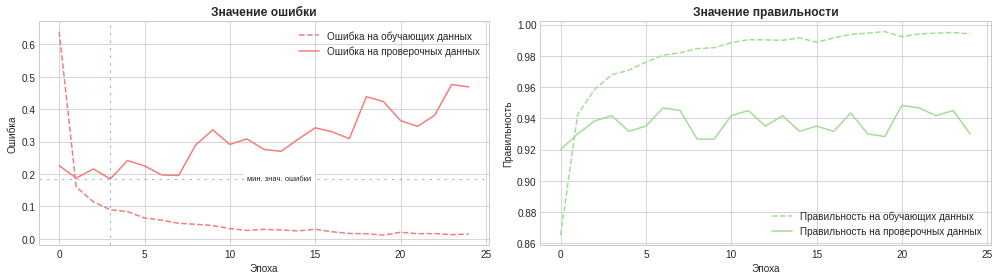

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_1e-4.csv', 'efficientnet', '224', 'adam', '1e-04')

### Тестирование

In [85]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [87]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
efficientnet = get_efficientnetb0(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/efficientnet_224_adam_1e-04_cuda.pth')
train_preds = get_all_preds(efficientnet, train_dl)
test_preds = get_all_preds(efficientnet, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17266	Train Accuracy: 97.72%
Test Correct:    568	Test Accuracy:  94.67%


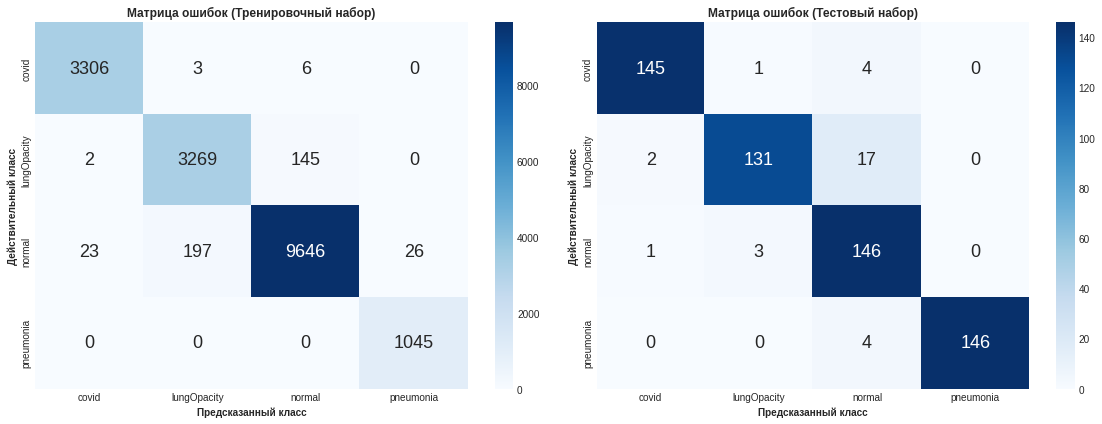

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'efficientnet', '224', 'adam', '1e-04')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9861111111111112
Recall: 0.9797297297297297
Precision: 0.9666666666666667
F1-score: 0.9731543624161074
 
Class name: lungOpacity
Accuracy: 0.961082910321489
Recall: 0.9703703703703703
Precision: 0.8733333333333333
F1-score: 0.9192982456140351
 
Class name: normal
Accuracy: 0.9514237855946399
Recall: 0.8538011695906432
Precision: 0.9733333333333334
F1-score: 0.9096573208722741
 
Class name: pneumonia
Accuracy: 0.993006993006993
Recall: 1.0
Precision: 0.9733333333333334
F1-score: 0.9864864864864865
 


In [ ]:
0.986111
0.979729
0.966667
0.973154
 
0.961083
0.970370
0.873333
0.919298

0.951424
0.853801
0.973333
0.909657
 
0.993007
1.000000
0.973333
0.986486

## EfficientNet 224 adam 1e-05

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
efficientnet = get_efficientnetb0(pretrained=True, out_features=4)

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(efficientnet.parameters(), lr=1e-05)

In [ ]:
fit(
    epochs=epochs,
    model=efficientnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    size=224,
    lr = 1e-05
)

Epoch [ 1/25]: 100%|██████████| 553/553 [01:54<00:00,  4.81it/s, acc=0.528, loss=0.123]



		Avg train loss: 3.273292	Avg valid loss: 0.864520

		valid_loss decreased (inf -> 0.864520)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [01:45<00:00,  5.23it/s, acc=0.861, loss=1.95]



		Avg train loss: 0.606007	Avg valid loss: 0.445562

		valid_loss decreased (0.864520 -> 0.445562)
		saving model...



Epoch [ 3/25]: 100%|██████████| 553/553 [01:47<00:00,  5.15it/s, acc=0.895, loss=0.568]



		Avg train loss: 0.354202	Avg valid loss: 0.355277

		valid_loss decreased (0.445562 -> 0.355277)
		saving model...



Epoch [ 4/25]: 100%|██████████| 553/553 [01:46<00:00,  5.18it/s, acc=0.908, loss=1.79]



		Avg train loss: 0.276828	Avg valid loss: 0.278271

		valid_loss decreased (0.355277 -> 0.278271)
		saving model...



Epoch [ 5/25]: 100%|██████████| 553/553 [01:46<00:00,  5.19it/s, acc=0.917, loss=0.653]



		Avg train loss: 0.246601	Avg valid loss: 0.243195

		valid_loss decreased (0.278271 -> 0.243195)
		saving model...



Epoch [ 6/25]: 100%|██████████| 553/553 [01:47<00:00,  5.14it/s, acc=0.93, loss=0.0824]



		Avg train loss: 0.202738	Avg valid loss: 0.256065



Epoch [ 7/25]: 100%|██████████| 553/553 [01:47<00:00,  5.15it/s, acc=0.935, loss=0.0423]



		Avg train loss: 0.182120	Avg valid loss: 0.250091



Epoch [ 8/25]: 100%|██████████| 553/553 [01:47<00:00,  5.16it/s, acc=0.94, loss=0.0131]



		Avg train loss: 0.166932	Avg valid loss: 0.215267

		valid_loss decreased (0.243195 -> 0.215267)
		saving model...



Epoch [ 9/25]: 100%|██████████| 553/553 [01:47<00:00,  5.15it/s, acc=0.949, loss=1.17]



		Avg train loss: 0.148212	Avg valid loss: 0.207242

		valid_loss decreased (0.215267 -> 0.207242)
		saving model...



Epoch [10/25]: 100%|██████████| 553/553 [01:47<00:00,  5.15it/s, acc=0.948, loss=0.351]



		Avg train loss: 0.143414	Avg valid loss: 0.200575

		valid_loss decreased (0.207242 -> 0.200575)
		saving model...



Epoch [11/25]: 100%|██████████| 553/553 [01:47<00:00,  5.16it/s, acc=0.955, loss=0.229]



		Avg train loss: 0.125243	Avg valid loss: 0.180886

		valid_loss decreased (0.200575 -> 0.180886)
		saving model...



Epoch [12/25]: 100%|██████████| 553/553 [01:53<00:00,  4.87it/s, acc=0.957, loss=0.313]



		Avg train loss: 0.117759	Avg valid loss: 0.200699



Epoch [13/25]: 100%|██████████| 553/553 [01:52<00:00,  4.90it/s, acc=0.957, loss=0.442]



		Avg train loss: 0.117154	Avg valid loss: 0.224449



Epoch [14/25]: 100%|██████████| 553/553 [01:58<00:00,  4.68it/s, acc=0.963, loss=0.112]



		Avg train loss: 0.103934	Avg valid loss: 0.199155



Epoch [15/25]: 100%|██████████| 553/553 [01:55<00:00,  4.79it/s, acc=0.962, loss=2.59]



		Avg train loss: 0.104756	Avg valid loss: 0.215091



Epoch [16/25]: 100%|██████████| 553/553 [02:02<00:00,  4.51it/s, acc=0.964, loss=0.369]



		Avg train loss: 0.098281	Avg valid loss: 0.188914



Epoch [17/25]: 100%|██████████| 553/553 [02:00<00:00,  4.58it/s, acc=0.969, loss=0.00988]



		Avg train loss: 0.088952	Avg valid loss: 0.197362



Epoch [18/25]: 100%|██████████| 553/553 [02:02<00:00,  4.50it/s, acc=0.97, loss=0.000541]



		Avg train loss: 0.079334	Avg valid loss: 0.192700



Epoch [19/25]: 100%|██████████| 553/553 [02:04<00:00,  4.44it/s, acc=0.971, loss=0.306]



		Avg train loss: 0.079516	Avg valid loss: 0.228192



Epoch [20/25]: 100%|██████████| 553/553 [02:04<00:00,  4.44it/s, acc=0.973, loss=0.0297]



		Avg train loss: 0.071911	Avg valid loss: 0.211360



Epoch [21/25]: 100%|██████████| 553/553 [02:04<00:00,  4.43it/s, acc=0.976, loss=0.0499]



		Avg train loss: 0.067706	Avg valid loss: 0.238846



Epoch [22/25]: 100%|██████████| 553/553 [02:04<00:00,  4.43it/s, acc=0.977, loss=0.146]



		Avg train loss: 0.064498	Avg valid loss: 0.223204



Epoch [23/25]: 100%|██████████| 553/553 [02:07<00:00,  4.35it/s, acc=0.976, loss=0.392]



		Avg train loss: 0.063928	Avg valid loss: 0.186546



Epoch [24/25]: 100%|██████████| 553/553 [02:06<00:00,  4.36it/s, acc=0.979, loss=0.00853]



		Avg train loss: 0.058681	Avg valid loss: 0.217521



Epoch [25/25]: 100%|██████████| 553/553 [02:07<00:00,  4.35it/s, acc=0.98, loss=0.0146]



		Avg train loss: 0.058367	Avg valid loss: 0.258724



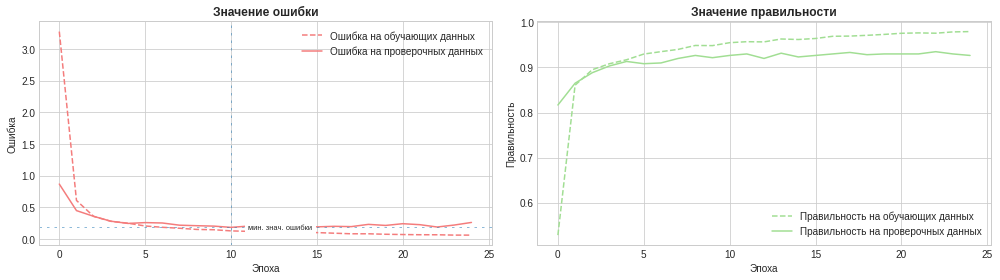

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_1e-05.csv', 'efficientnet', '224', 'adam', '1e-05')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
efficientnet = get_efficientnetb0(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/efficientnet_224_adam_1e-05_cuda.pth')
train_preds = get_all_preds(efficientnet, train_dl)
test_preds = get_all_preds(efficientnet, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17065	Train Accuracy: 96.59%
Test Correct:    566	Test Accuracy:  94.33%


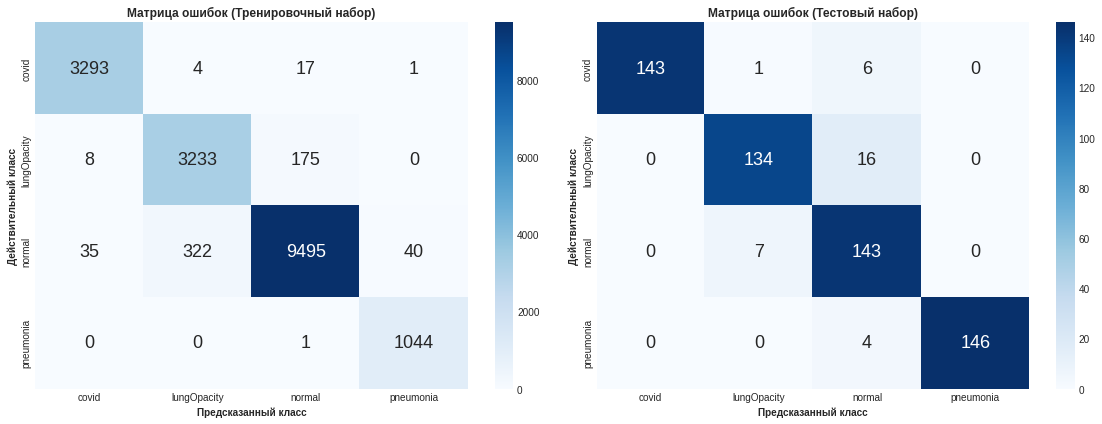

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'efficientnet', '224', 'adam', '1e-05')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.987783595113438
Recall: 1.0
Precision: 0.9533333333333334
F1-score: 0.9761092150170648
 
Class name: lungOpacity
Accuracy: 0.9593220338983051
Recall: 0.9436619718309859
Precision: 0.8933333333333333
F1-score: 0.9178082191780823
 
Class name: normal
Accuracy: 0.9449081803005008
Recall: 0.8461538461538461
Precision: 0.9533333333333334
F1-score: 0.896551724137931
 
Class name: pneumonia
Accuracy: 0.9929824561403509
Recall: 1.0
Precision: 0.9733333333333334
F1-score: 0.9864864864864865
 


In [ ]:
0.987784
1.000000
0.953333
0.976109
 
0.959322
0.943662
0.893333
0.917808
 
0.944908
0.846154
0.953333
0.896552
 
0.992982
1.000000
0.973333
0.986486

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
efficientnet = get_efficientnetb0(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/efficientnet_224_adam_1e-03_cuda.pth')
train_preds = get_all_preds(efficientnet, train_dl)
test_preds = get_all_preds(efficientnet, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17088	Train Accuracy: 96.72%
Test Correct:    576	Test Accuracy:  96.00%


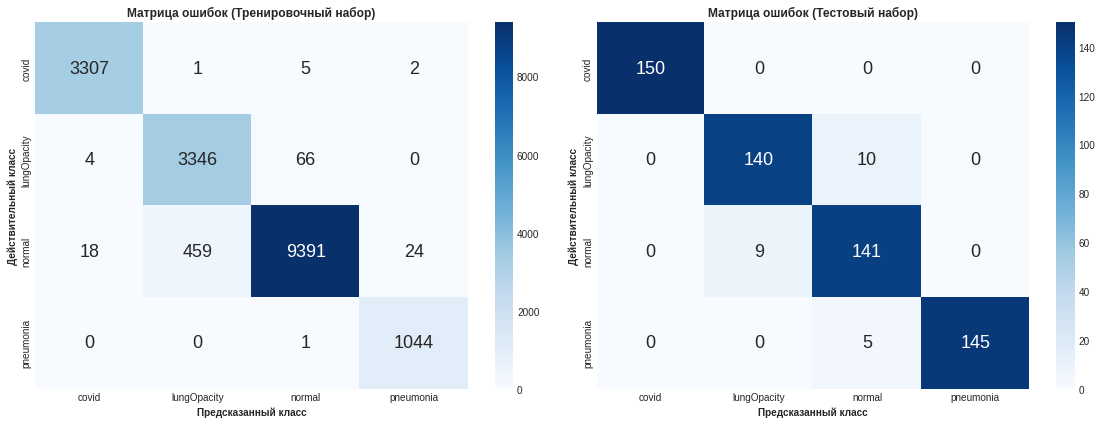

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'efficientnet', '224', 'adam', '1e-03')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0
 
Class name: lungOpacity
Accuracy: 0.9680672268907563
Recall: 0.9395973154362416
Precision: 0.9333333333333333
F1-score: 0.9364548494983278
 
Class name: normal
Accuracy: 0.96
Recall: 0.9038461538461539
Precision: 0.94
F1-score: 0.9215686274509804
 
Class name: pneumonia
Accuracy: 0.9913941480206541
Recall: 1.0
Precision: 0.9666666666666667
F1-score: 0.983050847457627
 


In [ ]:
Class name: lungOpacity
0.968067
0.939597
0.933333
0.936455
 
Class name: normal
0.960000
0.903846
0.940000
0.921569
 
Class name: pneumonia
0.991394
1.000000
0.966667
0.983051

## EfficientNet 224 adam cyclical_lr

### Загрузка данных

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [ ]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

### Обучение

In [ ]:
def cyclical_lr(stepsize, min_lr=1.5e-05, max_lr=9e-05):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
efficientnet = get_efficientnetb0(pretrained=True, out_features=4)

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer=optim.Adam(efficientnet.parameters(), lr=1.)

In [ ]:
step_size = 4*len(train_dl)

In [ ]:
lr_max = 9e-06

In [ ]:
factor = 6
end_lr = lr_max
iter=0
total_logs = []

In [ ]:
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)

In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [ ]:
fit_sheduler(
    epochs=epochs,
    model=efficientnet,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dl,
    valid_dl=valid_dl,
    size=224
)

Epoch [ 1/25]: 100%|██████████| 553/553 [02:09<00:00,  4.28it/s, acc=0.0056, loss=5.53]



		Avg train loss: 6.829307	Avg valid loss: 5.931449

		valid_loss decreased (inf -> 5.931449)
		saving model...



Epoch [ 2/25]: 100%|██████████| 553/553 [02:04<00:00,  4.45it/s, acc=0.163, loss=4.82]



		Avg train loss: 5.343117	Avg valid loss: 4.145401

		valid_loss decreased (5.931449 -> 4.145401)
		saving model...



Epoch [ 3/25]: 100%|██████████| 553/553 [02:11<00:00,  4.20it/s, acc=0.514, loss=2.69]



		Avg train loss: 3.657442	Avg valid loss: 2.555990

		valid_loss decreased (4.145401 -> 2.555990)
		saving model...



Epoch [ 4/25]: 100%|██████████| 553/553 [02:07<00:00,  4.33it/s, acc=0.713, loss=3.17]



		Avg train loss: 2.367335	Avg valid loss: 1.552699

		valid_loss decreased (2.555990 -> 1.552699)
		saving model...



Epoch [ 5/25]: 100%|██████████| 553/553 [02:01<00:00,  4.55it/s, acc=0.78, loss=2.89]



		Avg train loss: 1.617420	Avg valid loss: 1.192760

		valid_loss decreased (1.552699 -> 1.192760)
		saving model...



Epoch [ 6/25]: 100%|██████████| 553/553 [01:58<00:00,  4.68it/s, acc=0.814, loss=1.28]



		Avg train loss: 1.177843	Avg valid loss: 0.914703

		valid_loss decreased (1.192760 -> 0.914703)
		saving model...



Epoch [ 7/25]: 100%|██████████| 553/553 [01:58<00:00,  4.67it/s, acc=0.83, loss=0.147]



		Avg train loss: 0.918178	Avg valid loss: 0.821710

		valid_loss decreased (0.914703 -> 0.821710)
		saving model...



Epoch [ 8/25]: 100%|██████████| 553/553 [02:08<00:00,  4.30it/s, acc=0.845, loss=0.146]



		Avg train loss: 0.756261	Avg valid loss: 0.695160

		valid_loss decreased (0.821710 -> 0.695160)
		saving model...



Epoch [ 9/25]: 100%|██████████| 553/553 [02:02<00:00,  4.50it/s, acc=0.859, loss=2.62]



		Avg train loss: 0.620028	Avg valid loss: 0.617196

		valid_loss decreased (0.695160 -> 0.617196)
		saving model...



Epoch [10/25]: 100%|██████████| 553/553 [01:49<00:00,  5.03it/s, acc=0.868, loss=0.473]



		Avg train loss: 0.541537	Avg valid loss: 0.527848

		valid_loss decreased (0.617196 -> 0.527848)
		saving model...



Epoch [11/25]: 100%|██████████| 553/553 [01:50<00:00,  5.02it/s, acc=0.877, loss=1.5]



		Avg train loss: 0.468163	Avg valid loss: 0.495050

		valid_loss decreased (0.527848 -> 0.495050)
		saving model...



Epoch [12/25]: 100%|██████████| 553/553 [01:50<00:00,  5.01it/s, acc=0.882, loss=1.11]



		Avg train loss: 0.427502	Avg valid loss: 0.467162

		valid_loss decreased (0.495050 -> 0.467162)
		saving model...



Epoch [13/25]: 100%|██████████| 553/553 [01:49<00:00,  5.06it/s, acc=0.882, loss=0.494]



		Avg train loss: 0.413676	Avg valid loss: 0.472802



Epoch [14/25]: 100%|██████████| 553/553 [01:49<00:00,  5.05it/s, acc=0.891, loss=0.401]



		Avg train loss: 0.372901	Avg valid loss: 0.391457

		valid_loss decreased (0.467162 -> 0.391457)
		saving model...



Epoch [15/25]: 100%|██████████| 553/553 [01:49<00:00,  5.07it/s, acc=0.895, loss=2.39]



		Avg train loss: 0.354385	Avg valid loss: 0.410419



Epoch [16/25]: 100%|██████████| 553/553 [01:50<00:00,  5.02it/s, acc=0.897, loss=0.702]



		Avg train loss: 0.342179	Avg valid loss: 0.363075

		valid_loss decreased (0.391457 -> 0.363075)
		saving model...



Epoch [17/25]: 100%|██████████| 553/553 [01:49<00:00,  5.05it/s, acc=0.9, loss=0.116]



		Avg train loss: 0.319926	Avg valid loss: 0.355101

		valid_loss decreased (0.363075 -> 0.355101)
		saving model...



Epoch [18/25]: 100%|██████████| 553/553 [01:49<00:00,  5.05it/s, acc=0.906, loss=0.00606]



		Avg train loss: 0.291284	Avg valid loss: 0.329404

		valid_loss decreased (0.355101 -> 0.329404)
		saving model...



Epoch [19/25]: 100%|██████████| 553/553 [01:49<00:00,  5.04it/s, acc=0.904, loss=1.23]



		Avg train loss: 0.294143	Avg valid loss: 0.342797



Epoch [20/25]: 100%|██████████| 553/553 [01:49<00:00,  5.06it/s, acc=0.909, loss=0.0908]



		Avg train loss: 0.276265	Avg valid loss: 0.319779

		valid_loss decreased (0.329404 -> 0.319779)
		saving model...



Epoch [21/25]: 100%|██████████| 553/553 [01:50<00:00,  5.02it/s, acc=0.916, loss=0.96]



		Avg train loss: 0.252337	Avg valid loss: 0.310653

		valid_loss decreased (0.319779 -> 0.310653)
		saving model...



Epoch [22/25]: 100%|██████████| 553/553 [01:50<00:00,  4.99it/s, acc=0.914, loss=0.473]



		Avg train loss: 0.255282	Avg valid loss: 0.287766

		valid_loss decreased (0.310653 -> 0.287766)
		saving model...



Epoch [23/25]: 100%|██████████| 553/553 [01:49<00:00,  5.05it/s, acc=0.915, loss=0.829]



		Avg train loss: 0.249726	Avg valid loss: 0.281068

		valid_loss decreased (0.287766 -> 0.281068)
		saving model...



Epoch [24/25]: 100%|██████████| 553/553 [01:50<00:00,  5.01it/s, acc=0.917, loss=0.356]



		Avg train loss: 0.243328	Avg valid loss: 0.276623

		valid_loss decreased (0.281068 -> 0.276623)
		saving model...



Epoch [25/25]: 100%|██████████| 553/553 [01:49<00:00,  5.03it/s, acc=0.919, loss=0.165]



		Avg train loss: 0.237158	Avg valid loss: 0.273808

		valid_loss decreased (0.276623 -> 0.273808)
		saving model...



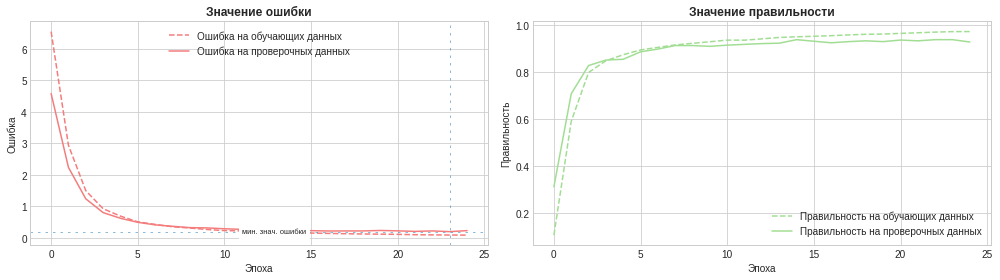

In [ ]:
plot_summary('../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_lambdalr.csv', 'densenet', '224', 'adam', 'lambdalr')

### Тестирование

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean_nums,
            std=std_nums
        )
    ])
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
densenet = get_densenet121(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/densenet_224_adam_lambdalr_cuda.pth')
train_preds = get_all_preds(densenet, train_dl)
test_preds = get_all_preds(densenet, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([17668, 1000]), torch.Size([600, 1000]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 17179	Train Accuracy: 97.23%
Test Correct:    565	Test Accuracy:  94.17%


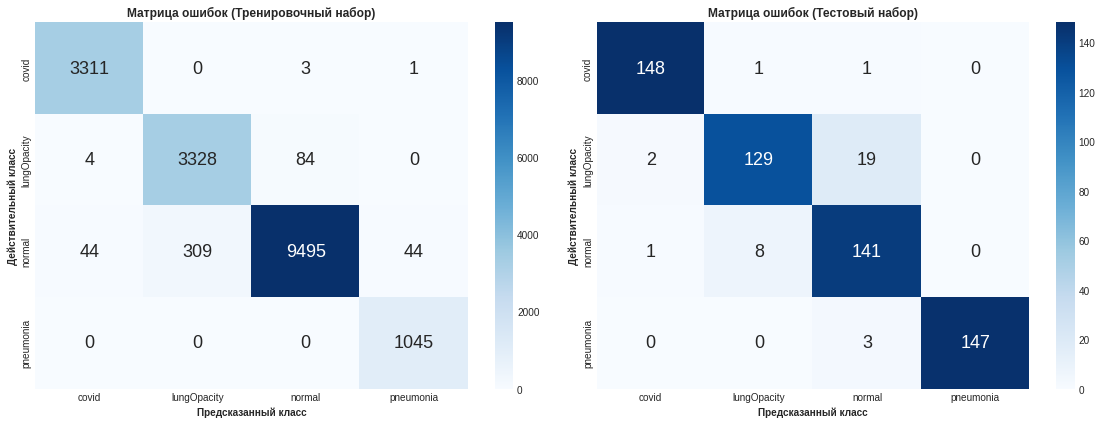

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, 'densenet', '224', 'adam', 'lambdalr')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

Class name: covid
Accuracy: 0.9930434782608696
Recall: 0.9932432432432432
Precision: 0.98
F1-score: 0.9865771812080537
 
Class name: lungOpacity
Accuracy: 0.9596638655462185
Recall: 0.95
Precision: 0.8866666666666667
F1-score: 0.9172413793103449
 
Class name: normal
Accuracy: 0.9532554257095158
Recall: 0.8719512195121951
Precision: 0.9533333333333334
F1-score: 0.9108280254777071
 
Class name: pneumonia
Accuracy: 0.9965095986038395
Recall: 1.0
Precision: 0.9866666666666667
F1-score: 0.9932885906040269
 


## Сравнение ошибки

In [52]:
path1 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_1e-03.csv'
path2 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_1e-04.csv'
path3 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_1e-05.csv'
path4 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_lambdalr.csv'

In [53]:
data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)
data4 = pd.read_csv(path4)

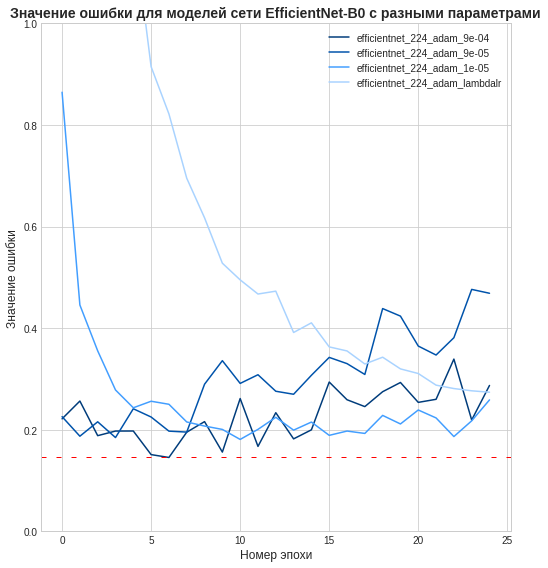

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_loss'], label='efficientnet_224_adam_9e-04', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_loss'], label='efficientnet_224_adam_9e-05', color="#0053AB")
ax.plot(data3['epoch'], data3['valid_loss'], label='efficientnet_224_adam_1e-05', color="#429EFF")
ax.plot(data4['epoch'], data4['valid_loss'], label='efficientnet_224_adam_lambdalr', color="#A9D3FF")
ax.axhline(min(min(data1['valid_loss']), min(data2['valid_loss']), min(data3['valid_loss']), min(data4['valid_loss'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")
ax.set_ylim(0, 1)

ax.legend()
ax.set_title('Значение ошибки для моделей сети EfficientNet-B0 с разными параметрами', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение ошибки', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/efficientnet_224_adam_loss_comparison.png')
plt.show()
plt.close()

## Сравнение правильность

In [54]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_acc'], label='EfficientNet-B0: 1x10^-5', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_acc'], label='EfficientNet-B0: 9x10^-4', color="#0053AB")
ax.plot(data3['epoch'], data3['valid_acc'], label='EfficientNet-B0: 9x10^-5', color="#429EFF")
ax.plot(data4['epoch'], data4['valid_acc'], label='EfficientNet-B0: [1.5x10^-5; 9x10^-5]', color="#A9D3FF")
ax.set_ylim(0.7, 1)
ax.axhline(max(max(data1['valid_acc']), max(data2['valid_acc']), max(data3['valid_acc']), max(data4['valid_acc'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend(loc = 'lower right', fontsize=12)
ax.set_title('Значение правильности для моделей сети EfficientNet-B0\nс разными параметрами скорости обучения', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение правильности', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/efficientnet_224_adam_acc_comparison.pdf')
plt.show()
plt.close()

# Сравнение ошибки всех

In [33]:
path1 = '/content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_lambdalr.csv'
path2 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_9.5e-05.csv'
path3 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_1e-03.csv'

In [34]:
data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_acc'], label='Resnet-18, скорость обучения: циклическая', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_acc'], label='Densenet-121, скорость обучения: 9.5x10^-5', color="#429EFF")
ax.plot(data3['epoch'], data3['valid_acc'], label='Efficientnet-B0, скорость обучения: 9x10^-4', color="#A9D3FF")
#ax.set_ylim(0, 1.5)
ax.axhline(max(max(data1['valid_acc']), max(data2['valid_acc']), max(data3['valid_acc'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend()
ax.set_title('Значение правильности выбранных моделей', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение правильности', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/all_acc_comparison_covid.png')
plt.show()
plt.close()

In [ ]:
path1 = '/content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_lambdalr.csv'
path2 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_9.5e-05.csv'
path3 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_lambdalr.csv'

In [ ]:
data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_acc'], label='Resnet-18, скорость обучения: циклическая', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_acc'], label='Densenet-121, скорость обучения: 9.5x10^-5', color="#429EFF")
ax.plot(data3['epoch'], data3['valid_acc'], label='Efficientnet-B0, скорость обучения: циклическая', color="#A9D3FF")
#ax.set_ylim(0, 1.5)
ax.axhline(max(max(data1['valid_acc']), max(data2['valid_acc']), max(data3['valid_acc'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend()
ax.set_title('Значение правильности выбранных моделей', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение правильности', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/all_acc_comparison_pneum.png')
plt.show()
plt.close()

In [35]:
path1 = '/content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_lambdalr.csv'
path2 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_9.5e-05.csv'
path3 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_1e-03.csv'

In [36]:
data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)

In [38]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_acc'], label='Resnet-18, скорость обучения: циклическая', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_acc'], label='Densenet-121, скорость обучения: 9.5x10^-5', color="#429EFF")
ax.plot(data3['epoch'], data3['valid_acc'], label='Efficientnet-B0, скорость обучения: 9x10^-4', color="#A9D3FF")
#ax.set_ylim(0, 1.5)
ax.axhline(max(max(data1['valid_acc']), max(data2['valid_acc']), max(data3['valid_acc'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend(loc ='lower right', fontsize=12)
ax.set_title('Значение правильности выбранных моделей', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение правильности', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/all_acc_comparison_lungOp.png')
plt.show()
plt.close()

In [ ]:
path1 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/resnet_224_adam_3e-04.csv'
path2 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/densenet_224_adam_9.5e-05.csv'
path3 = '../content/drive/MyDrive/DashaDiplom/outputs/CSVs/efficientnet_224_adam_1e-03.csv'

In [ ]:
data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot()
ax.plot(data1['epoch'], data1['valid_acc'], label='Resnet-18, скорость обучения: 3x10^-4', color="#003C7B")
ax.plot(data2['epoch'], data2['valid_acc'], label='Densenet-121, скорость обучения: 9.5x10^-5', color="#429EFF")
ax.plot(data3['epoch'], data3['valid_acc'], label='Efficientnet-B0, скорость обучения: 9x10^-4', color="#A9D3FF")
#ax.set_ylim(0, 1.5)
ax.axhline(max(max(data1['valid_acc']), max(data2['valid_acc']), max(data3['valid_acc'])),
           linestyle=(0, (5, 10)), linewidth=1, color="red")

ax.legend()
ax.set_title('Значение правильности выбранных моделей', fontweight='bold', fontsize=14)
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение правильности', fontsize=12)
ax.grid(True)

plt.tight_layout()
fig.savefig(f'../content/drive/MyDrive/DashaDiplom/outputs/summary_plots/all_acc_comparison_norm.png')
plt.show()
plt.close()

# GradCam

In [78]:
resnet18 = get_resnet18(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/resnet_224_adam_lambdalr_cuda.pth')
densnet121 = get_densenet121(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/densenet_224_adam_9.5e-05_cuda.pth')
efficientnetb0 = get_efficientnetb0(out_features=4, path='../content/drive/MyDrive/DashaDiplom/models/efficientnet_224_adam_1e-03_cuda.pth')

In [121]:
image, label = test_set[357]
image = image.unsqueeze(dim=0).to(device)

cam_obj = GradCAM(model= resnet18, target_layer=resnet18.layer4[-1])
_, res_cam = cam_obj(image, label)

cam_obj = GradCAM(model= densnet121, target_layer=densnet121.features[-1])
_, dense_cam = cam_obj(image, label)

cam_obj = GradCAM(model= efficientnetb0, target_layer=efficientnetb0.features[0])
_, eff_cam = cam_obj(image, label)

plot_gradcam(image, dense_cam)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [122]:
label

2